In [248]:
import os
import sys
import numpy as np
import pickle
from matplotlib import pyplot as plt
import torch
import xarray as xr
from hydra import compose, initialize
from omegaconf import OmegaConf
import re

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.data.cpc_mrms_dataset import get_precip_era5_dataset, DailyAggregateRainfallDataset
from src.data.precip_datamodule import PrecipDataModule

In [249]:
p = "/scratch/yl241/data/rainfall_eval_LiT/conformal/precipitation_bounds.pkl"
with open(p, 'rb') as f:
    data = pickle.load(f)

for i in range(len(data['ub_fnames'])):
    print(f"#{i}: {data['ub_fnames'][i]}")

#0: /scratch/yl241/data/rainfall_eval_LiT/wassdiff_conformal_43/batch_0.pt0
#1: /scratch/yl241/data/rainfall_eval_LiT/wassdiff_conformal_31/batch_0.pt1
#2: /scratch/yl241/data/rainfall_eval_LiT/wassdiff_conformal_19/batch_0.pt2
#3: /scratch/yl241/data/rainfall_eval_LiT/wassdiff_conformal_0/batch_0.pt3
#4: /scratch/yl241/data/rainfall_eval_LiT/wassdiff_conformal_47/batch_0.pt4
#5: /scratch/yl241/data/rainfall_eval_LiT/wassdiff_conformal_41/batch_0.pt5
#6: /scratch/yl241/data/rainfall_eval_LiT/wassdiff_conformal_18/batch_0.pt6
#7: /scratch/yl241/data/rainfall_eval_LiT/wassdiff_conformal_46/batch_0.pt7
#8: /scratch/yl241/data/rainfall_eval_LiT/wassdiff_conformal_28/batch_0.pt8
#9: /scratch/yl241/data/rainfall_eval_LiT/wassdiff_conformal_29/batch_0.pt9
#10: /scratch/yl241/data/rainfall_eval_LiT/wassdiff_conformal_44/batch_0.pt10
#11: /scratch/yl241/data/rainfall_eval_LiT/wassdiff_conformal_4/batch_0.pt11
#12: /scratch/yl241/data/rainfall_eval_LiT/wassdiff_conformal_32/batch_0.pt12
#13: /sc

## Interesting samples

In [250]:
with initialize(version_base=None, config_path="../configs", job_name="evaluation"):
    overrides = ["trainer.devices=[0]", "experiment=eval_val_set_conformal"]
    cfg = compose(config_name="eval", overrides=overrides)

data_module = PrecipDataModule(cfg.data.data_config, dataloader_mode=cfg.data.dataloader_mode,
                              use_test_samples_from=cfg.data.use_test_samples_from,
                              stop_at_batch=cfg.data.stop_at_batch)
data_module.setup(stage="test")
test_loader = data_module.test_dataloader()
precip_dataset = data_module.precip_dataset
len(test_loader)

Using precomputed MRMS daily aggregates
Using precomputed ERA5 daily aggregates
Using precomputed CPC daily aggregates
Loaded MRMS dataset containing 2428 daily aggregates
Using log + 1 normalization for precipitation


7

### Visualizing batches

In [251]:
def extract_conformal_idx(data: dict, idx: int):
    line = data['ub_fnames'][idx]
    # regular expressions to extract the integers based on their positions
    x = re.search(r"batch_(\d+)", line)  # Extract integer after "batch_"
    y = re.search(r"pt(\d+)", line)         # Extract integer after "pt"
    # extracted values
    x = int(x.group(1)) if x else None
    y = int(y.group(1)) if y else None
    path_ = f'/scratch/yl241/data/rainfall_eval_LiT/wassdiff_conformal_0/batch_{x}.pt'
    tensor_batch = torch.load(path_)
    return tensor_batch, x, y
    
def select_sample(t: torch.Tensor, y: int):
    """Assigns fake coordiates"""
    xarray_batch = {}
    for k, v in t.items():
        sample = v[y, 0, :, :]
        da = xr.DataArray(sample, name=k, dims=['lat', 'lon'])
        xarray_batch[k] = da.assign_coords(lat=np.arange(da.sizes["lat"])[::-1], lon=np.arange(da.sizes["lon"]))
    return xarray_batch

def vis_idx(data: dict, idx: int):
    tensor_batch, x, y = extract_conformal_idx(data, idx)
    xr_sample = select_sample(tensor_batch, y)
    xr_sample_composite = precip_dataset.create_composite_xarray_batch(xr_sample)
    precip_dataset.plot_composite_xarray_batch(batch=xr_sample_composite, rainfall_vis_max=None, save_dir=None, save_netcdf=False)

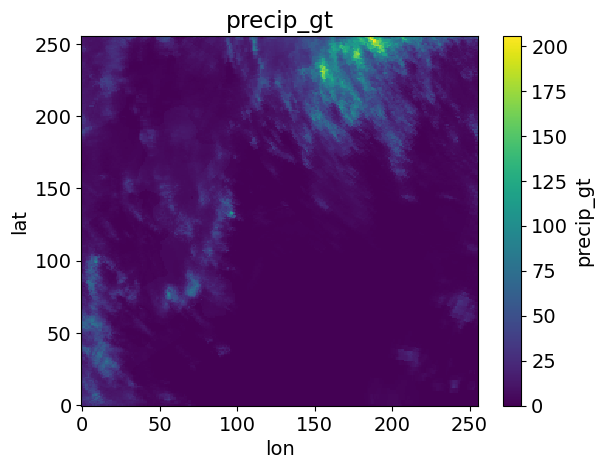

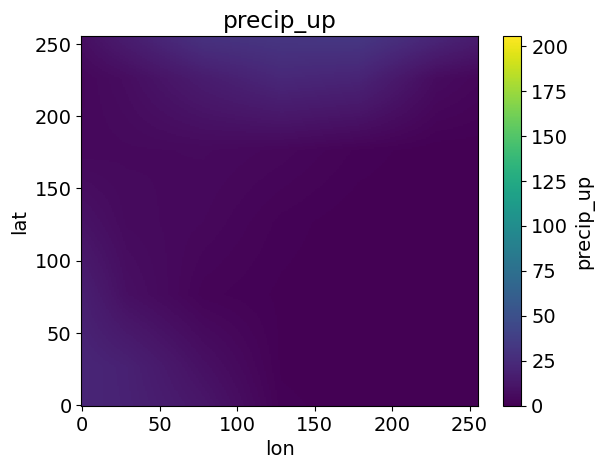

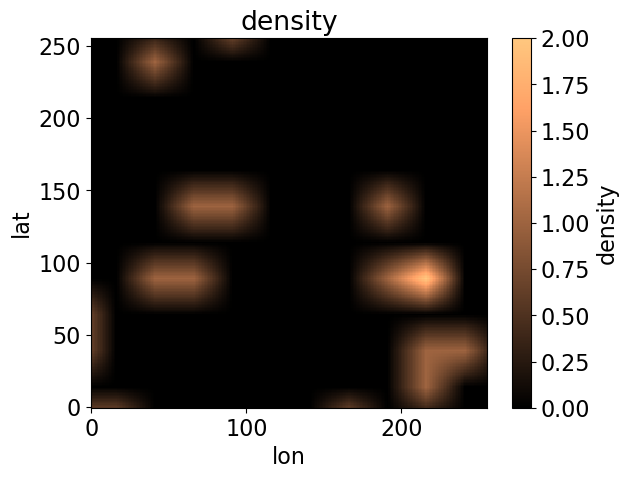

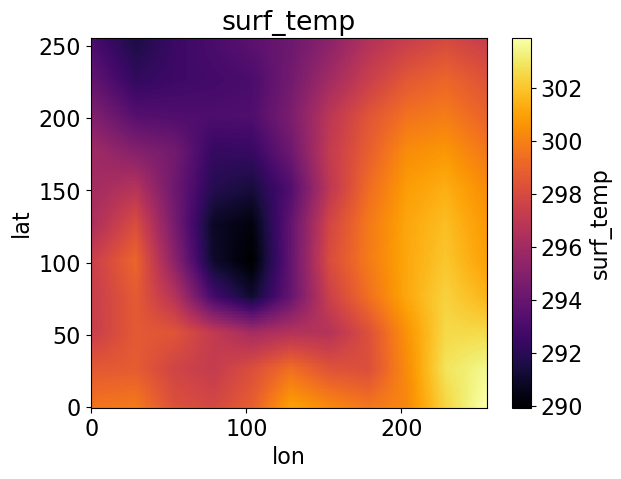

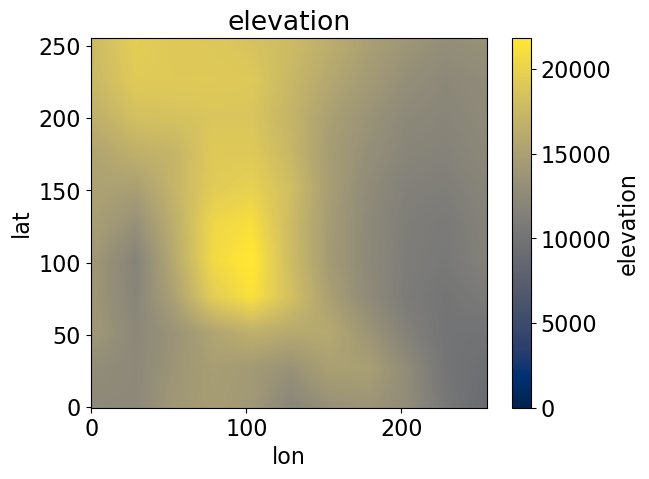

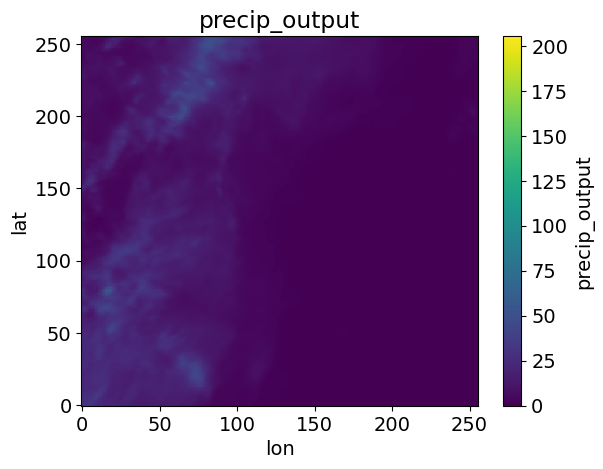

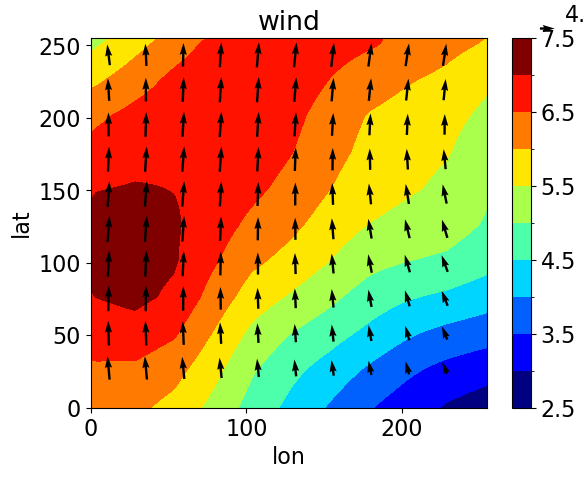

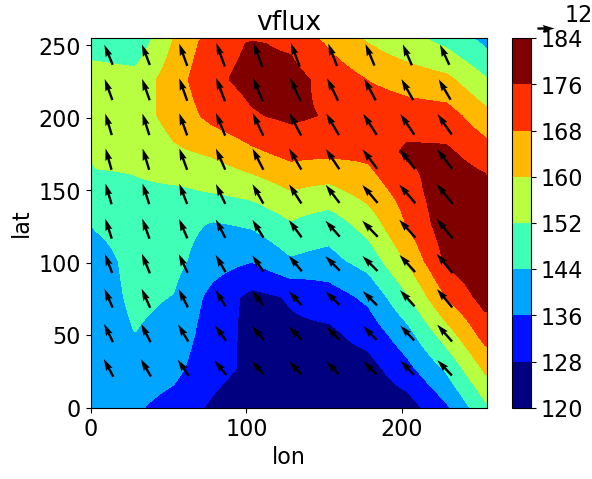

In [252]:
vis_idx(data, idx=160) # 0/#160 - GT might be a storm. UB somewhat reflects it, LB does not

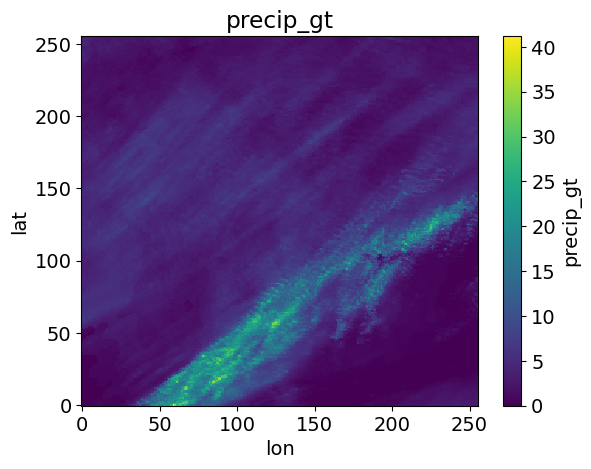

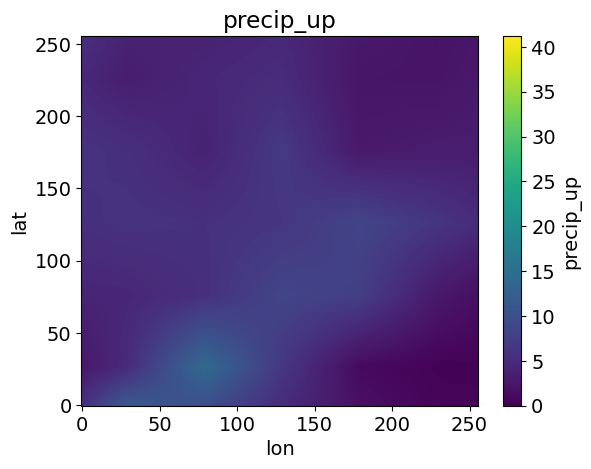

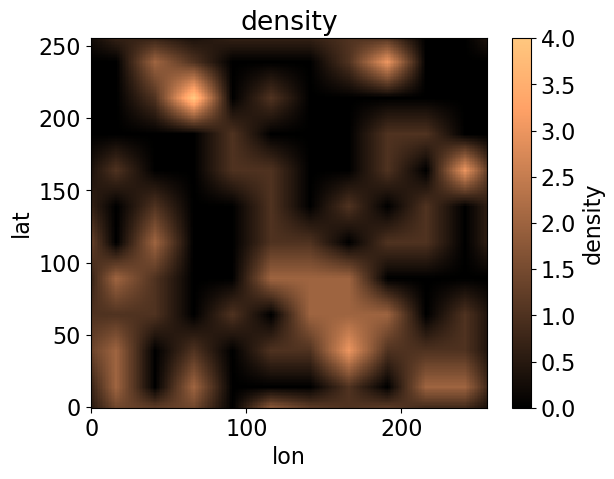

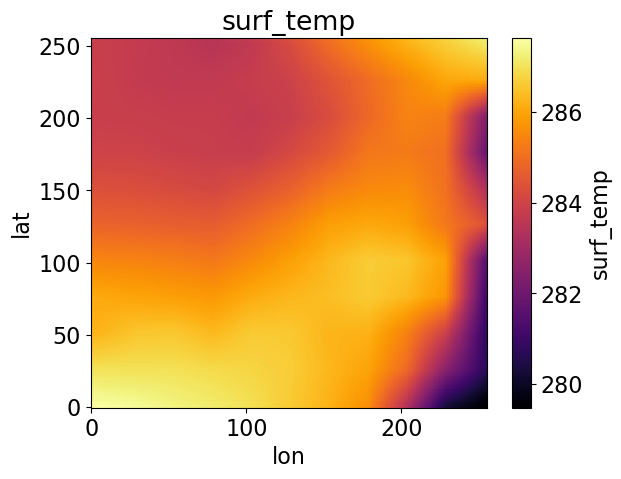

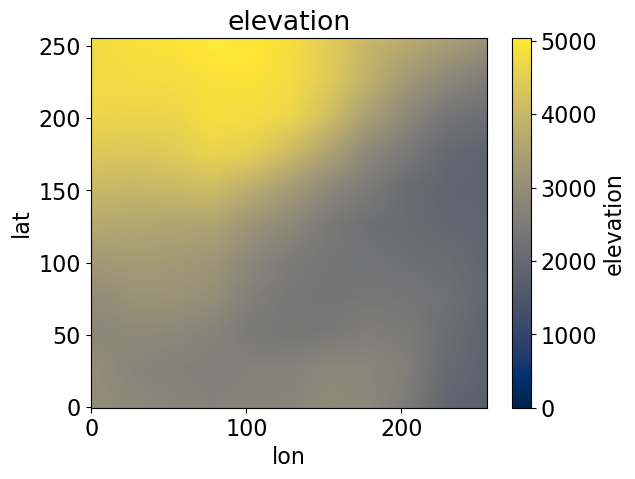

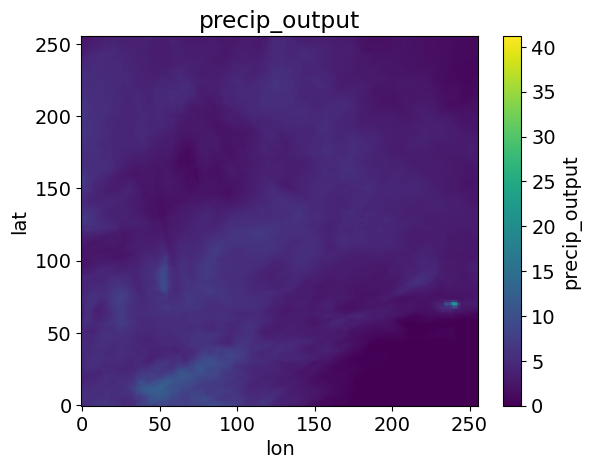

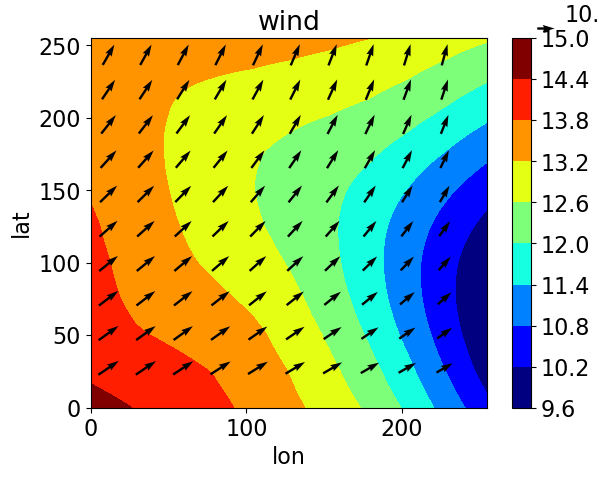

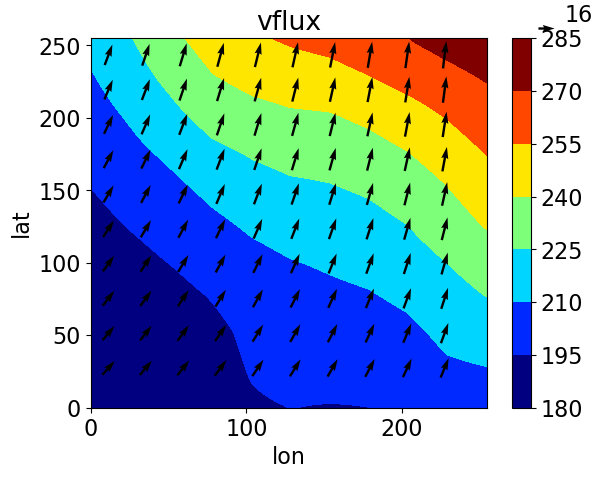

In [242]:
vis_idx(data, idx=142) # 8/#142 - GT might suggest a frontal system; LB reflects it, UB does not

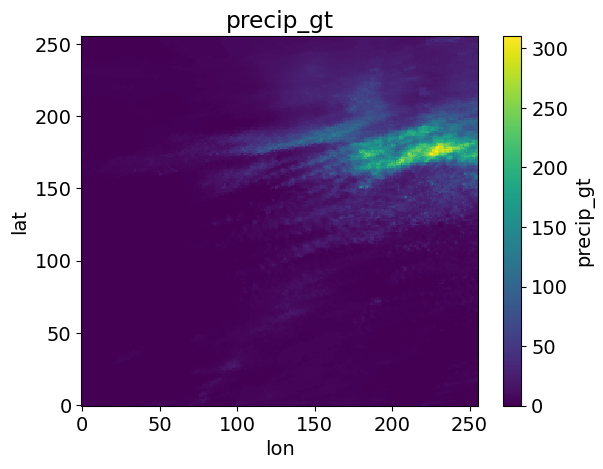

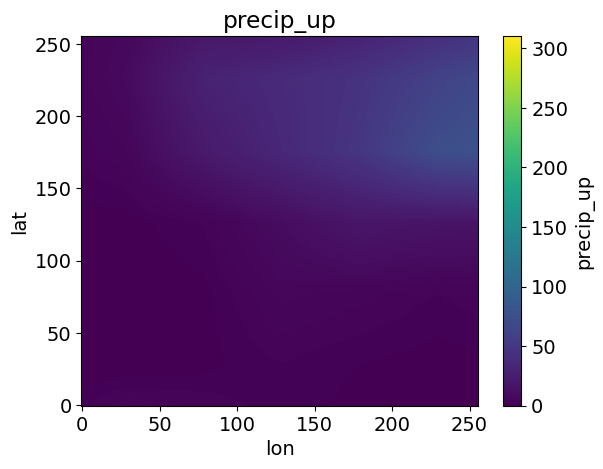

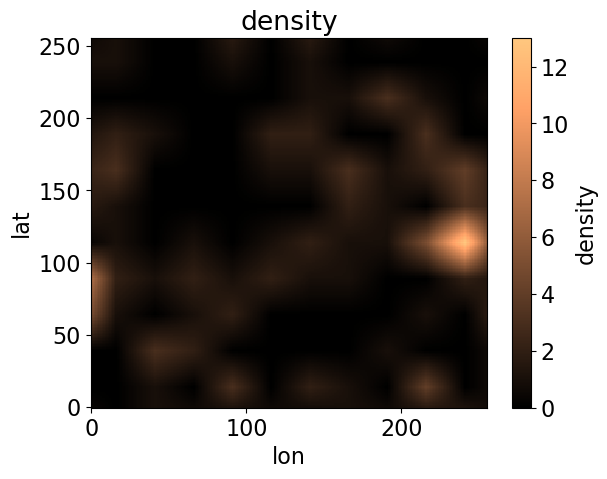

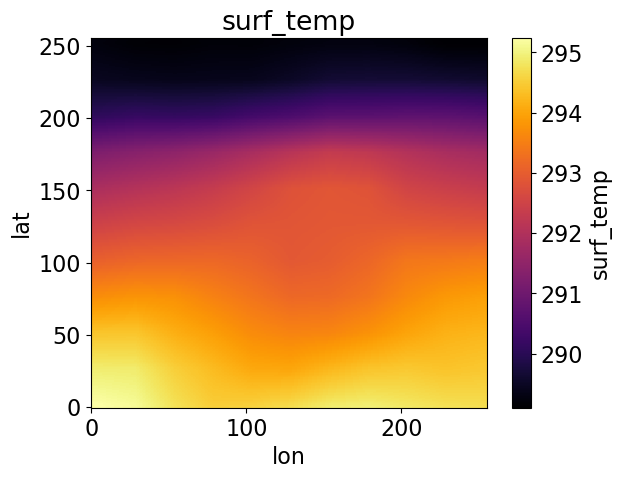

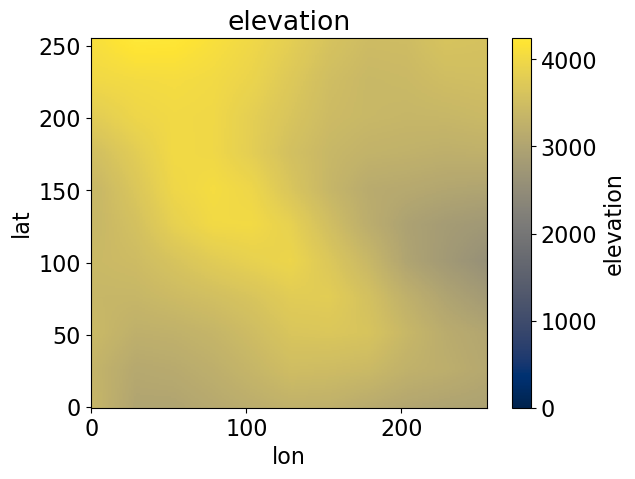

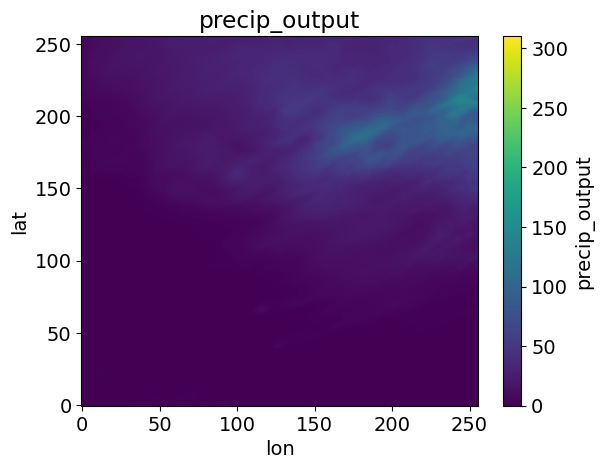

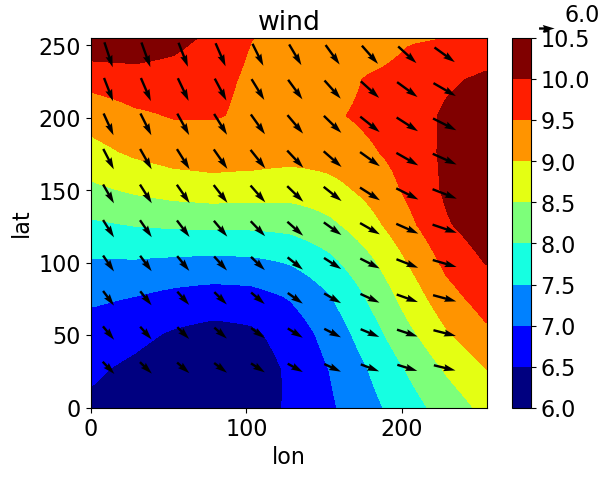

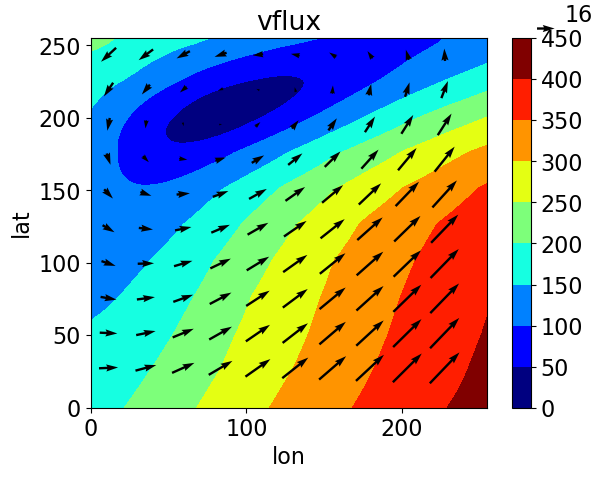

In [243]:
vis_idx(data, idx=29) # 24 / #29 - UB and GT have localized strong rainfall ; LB does not

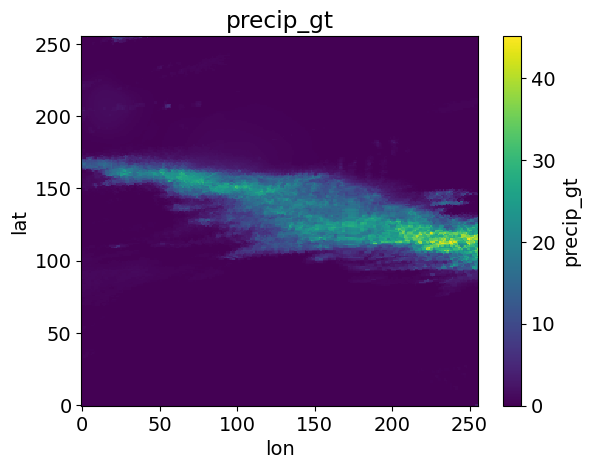

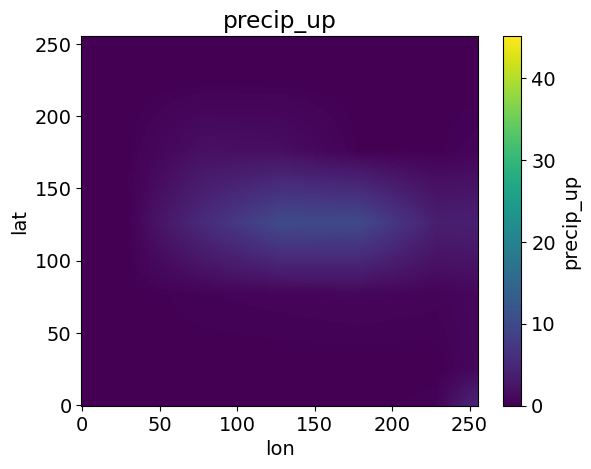

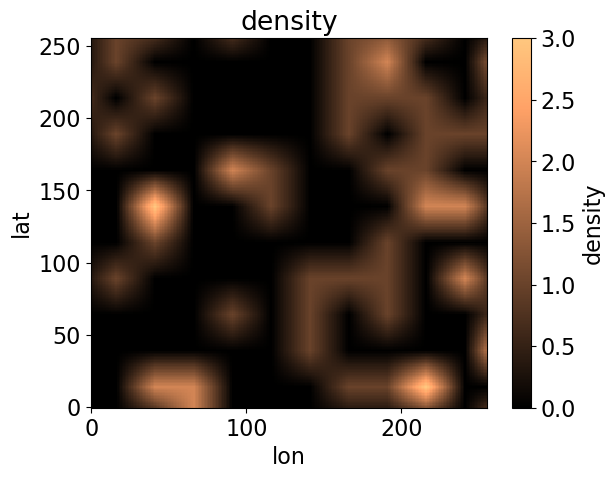

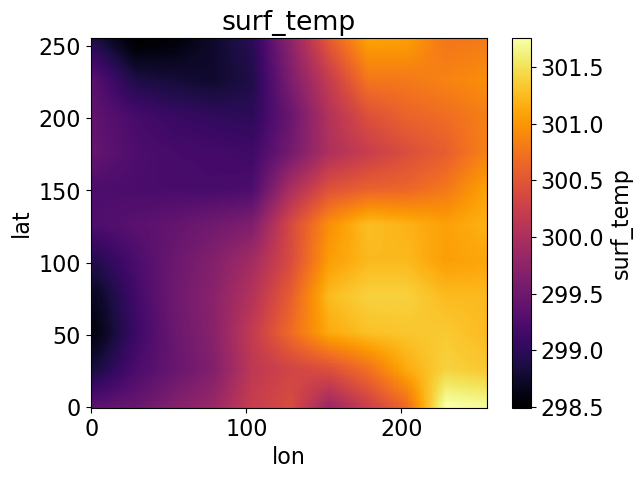

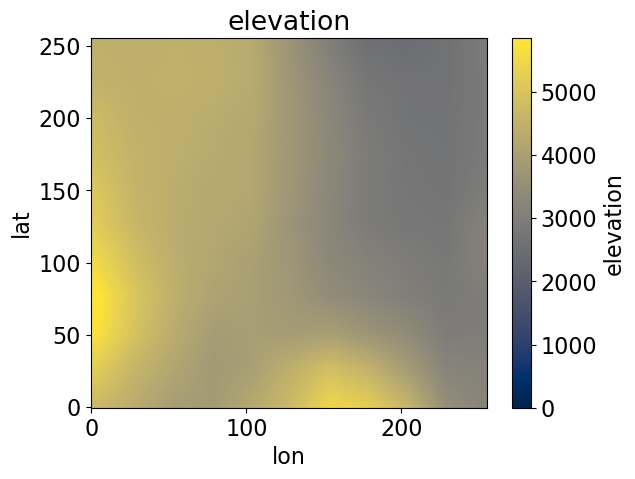

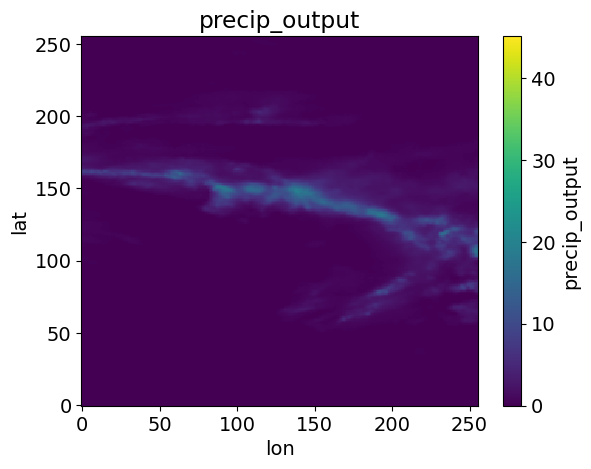

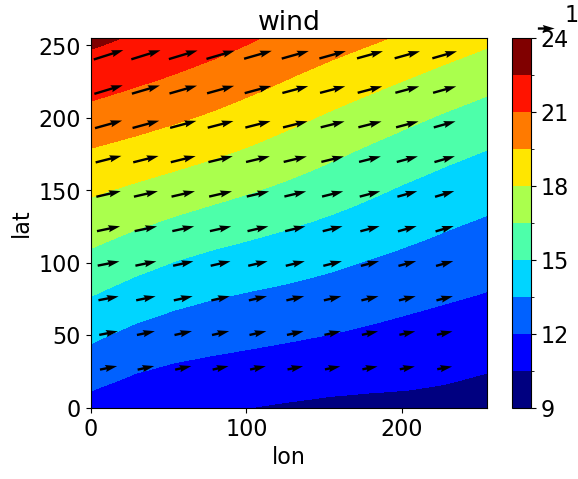

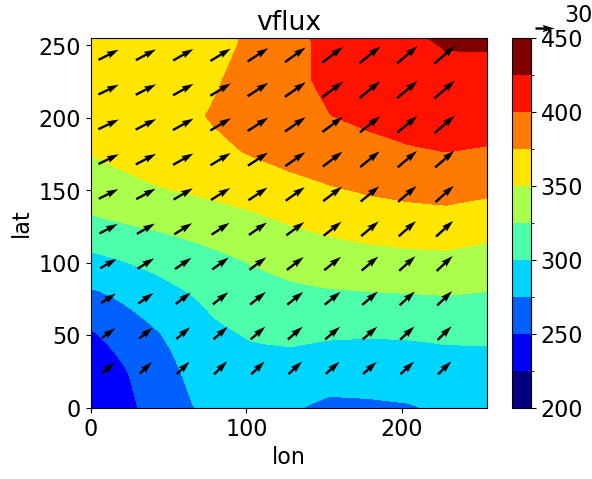

In [244]:
vis_idx(data, idx=43) # 28 / #43 - LB has no rainfall

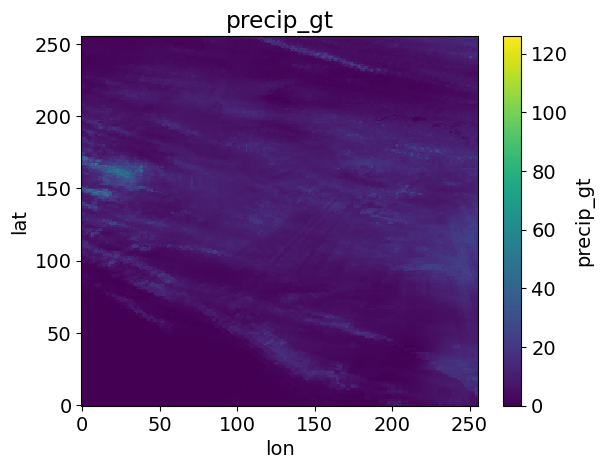

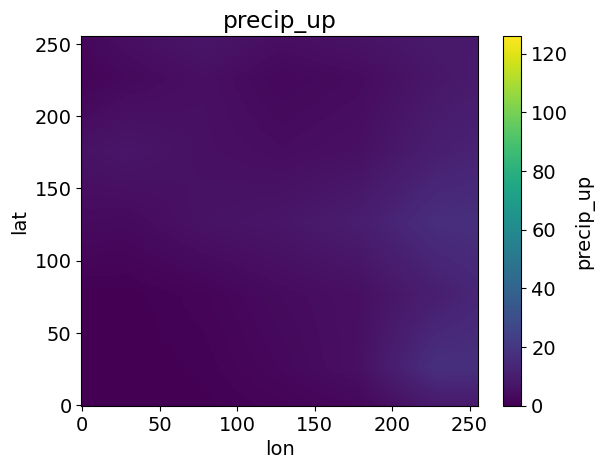

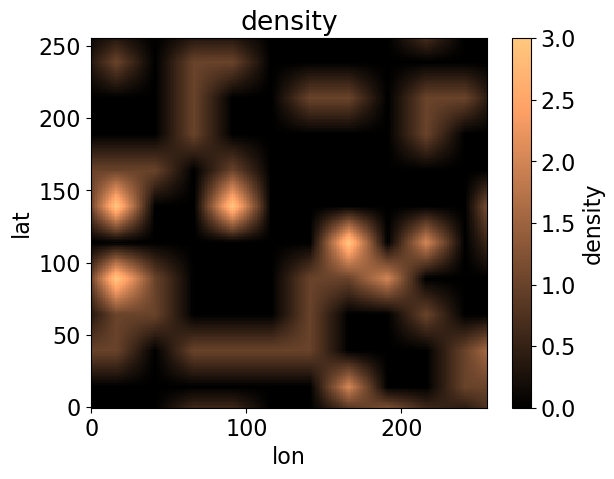

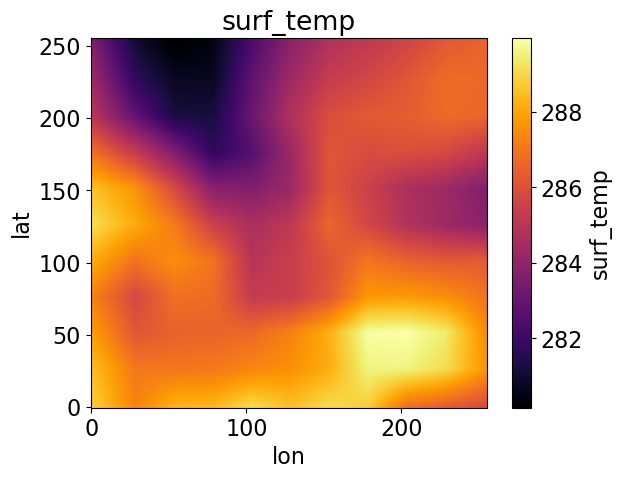

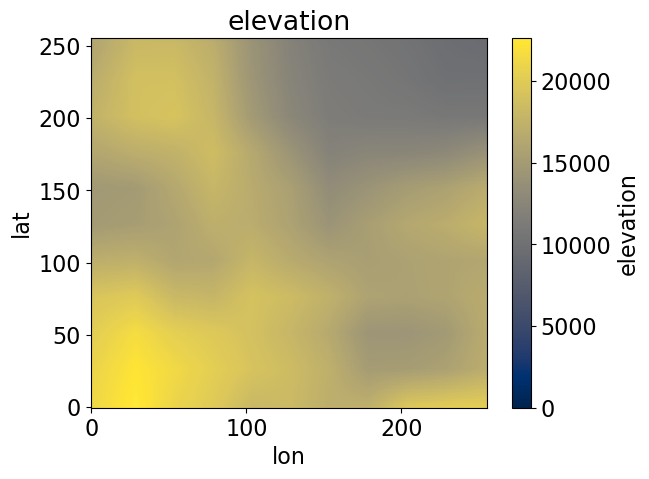

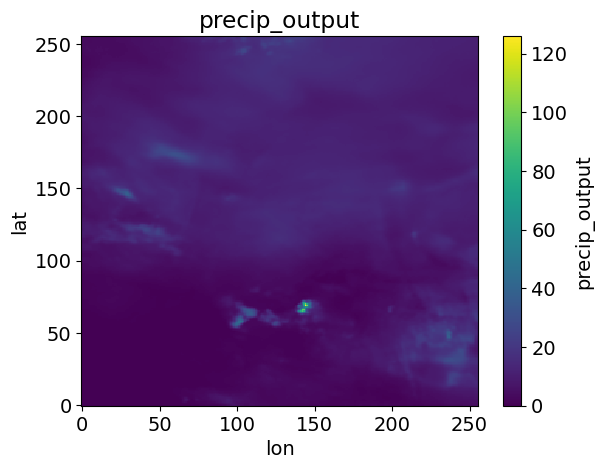

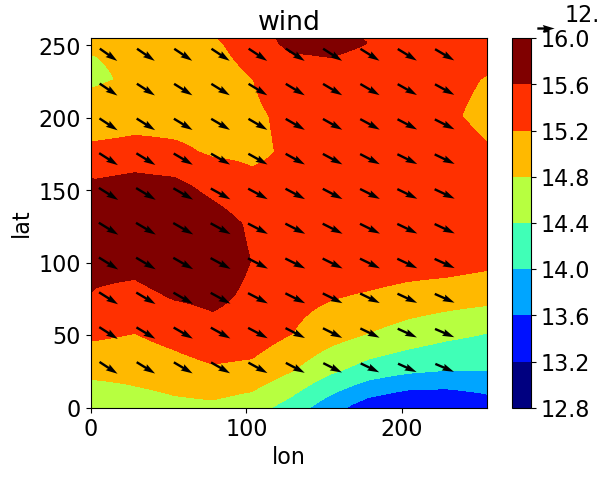

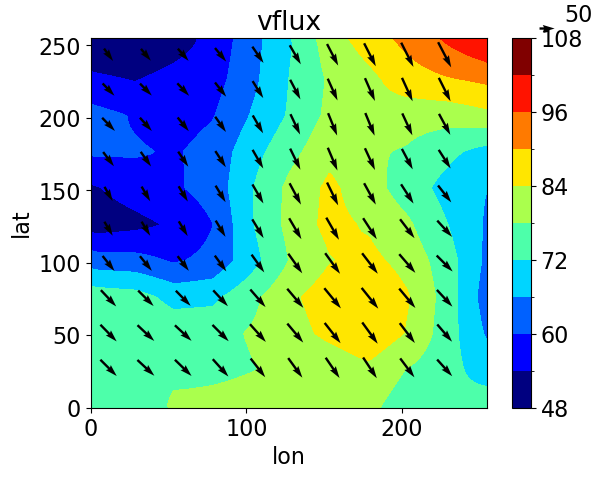

In [245]:
vis_idx(data, idx=168) # 28 / #168 - is there a boundary that is picked up by UP and GT but not LB

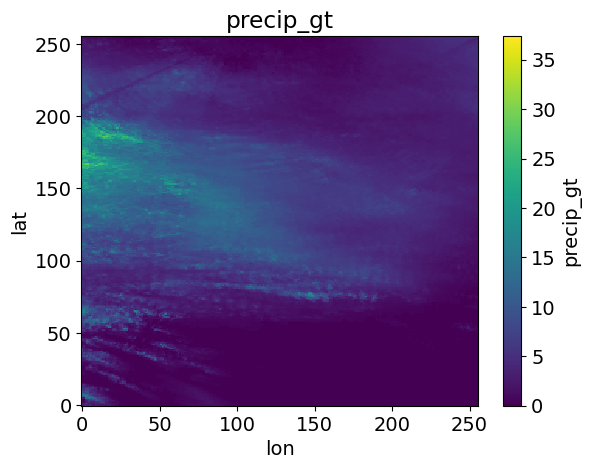

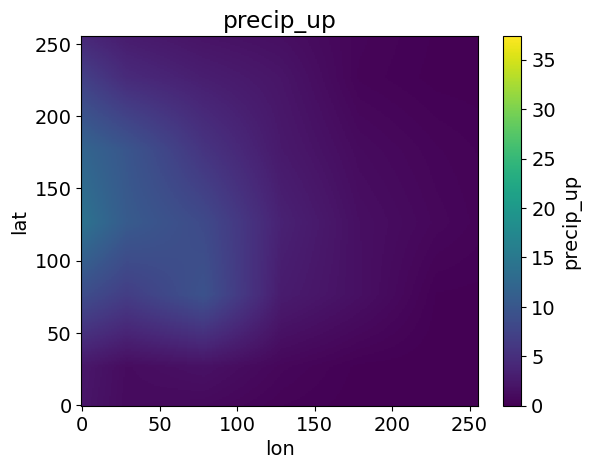

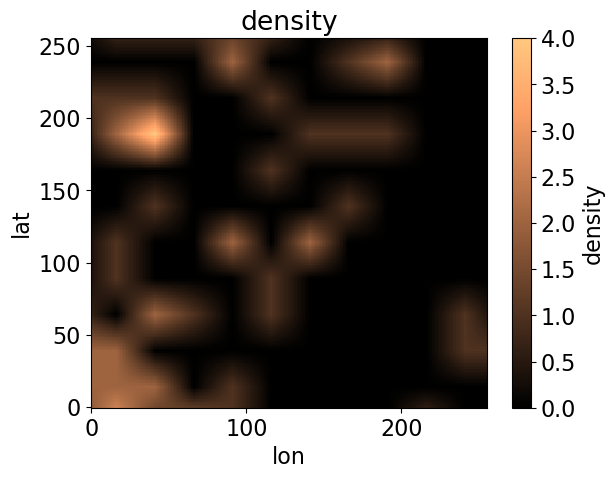

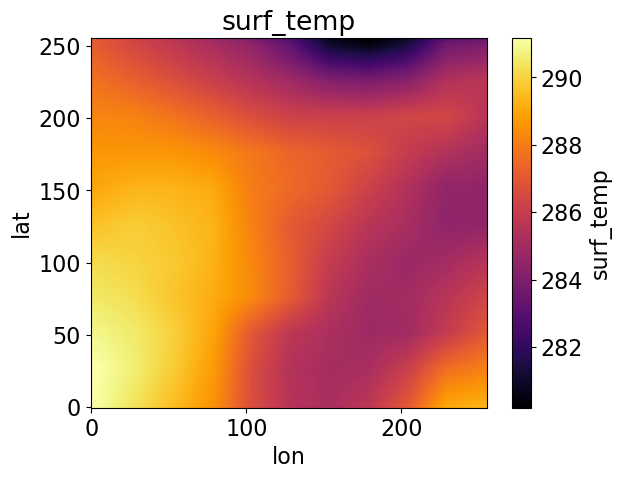

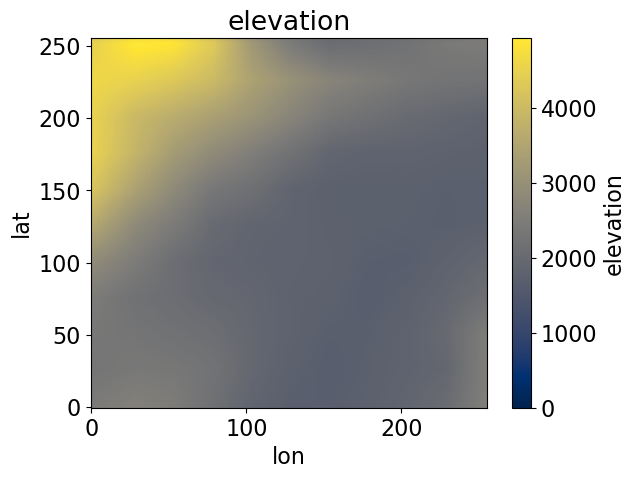

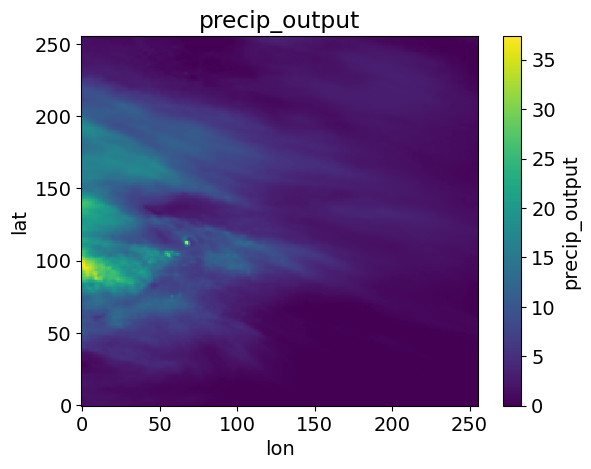

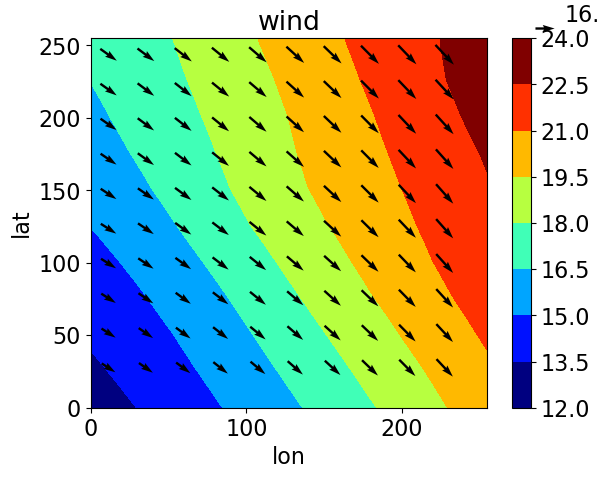

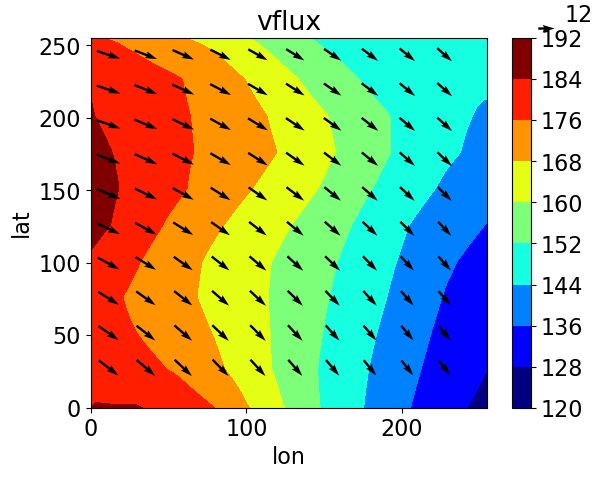

In [246]:
vis_idx(data, idx=18) # 33 / #18 - LB has no stipes

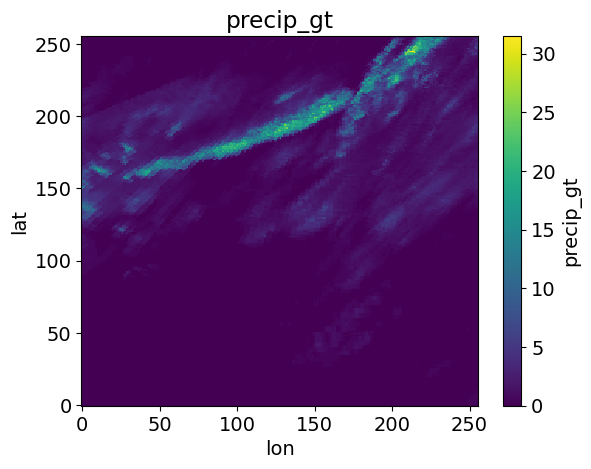

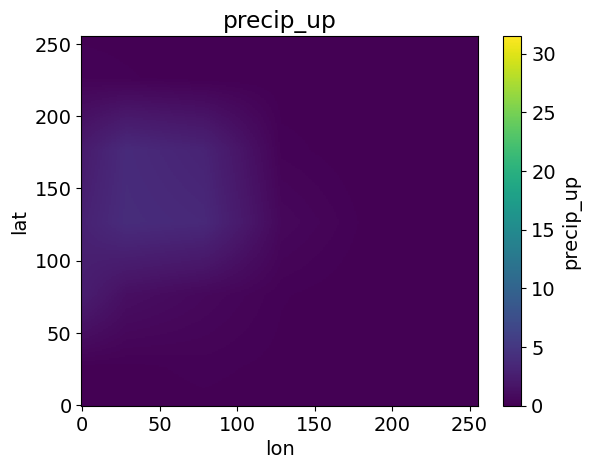

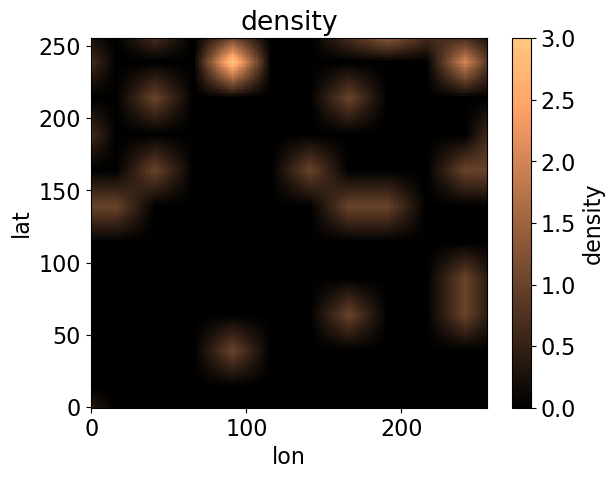

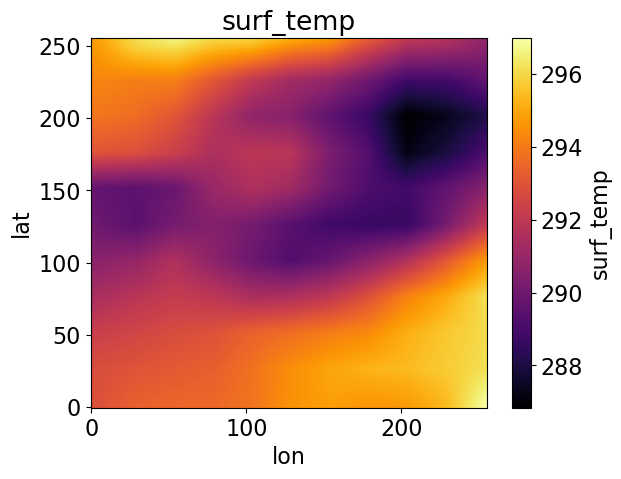

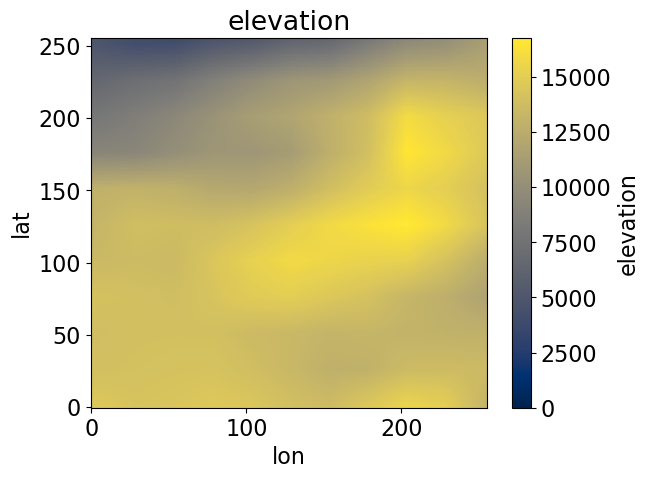

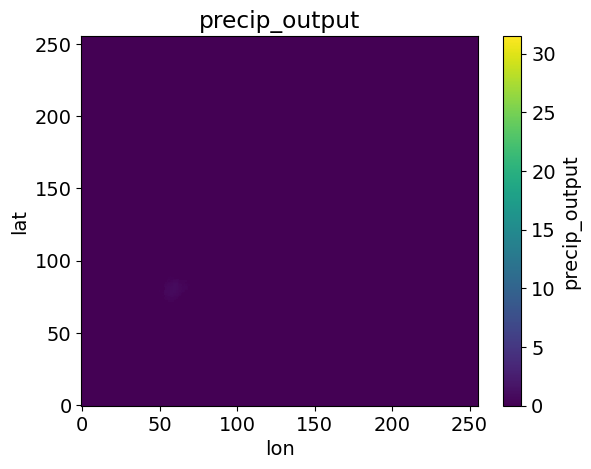

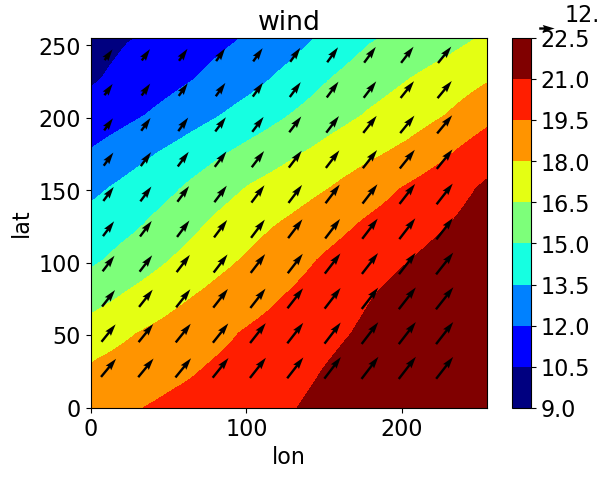

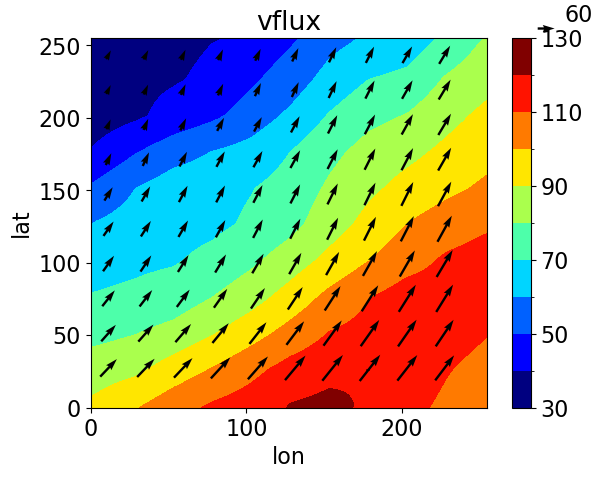

In [247]:
vis_idx(data, idx=88) # 34 / #88 - GT and UB have a strong stripe, LB does not

### More examples

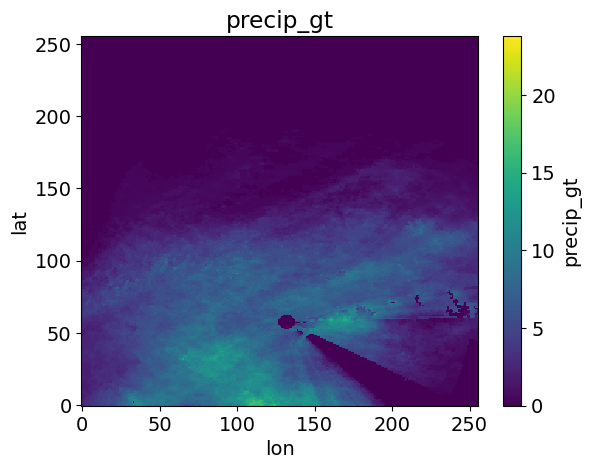

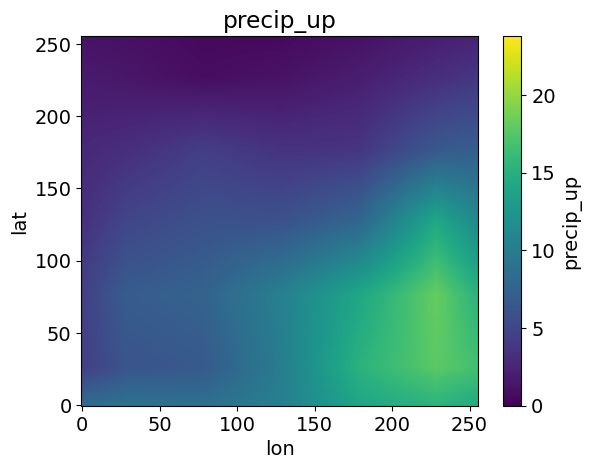

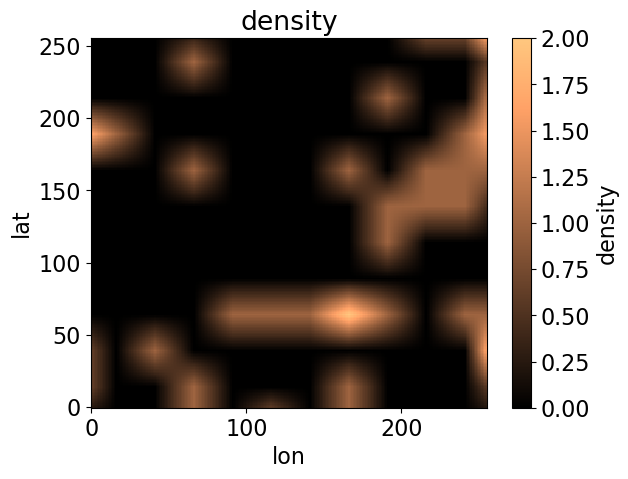

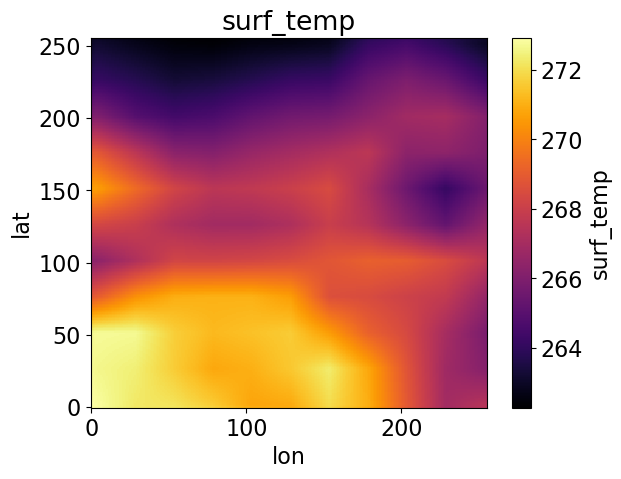

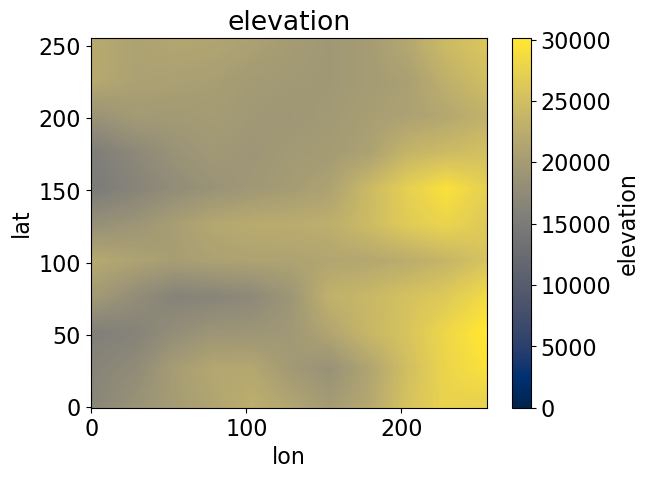

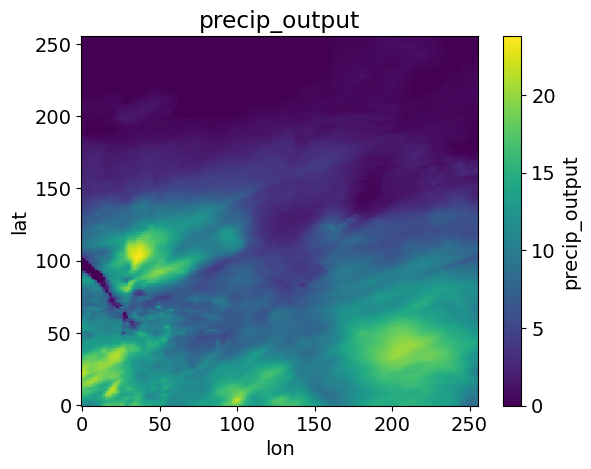

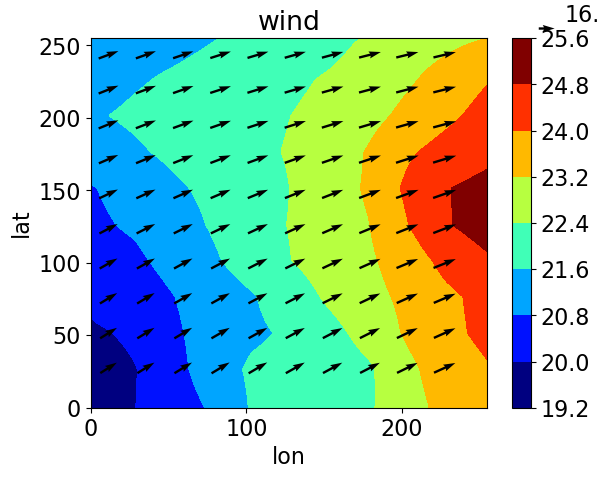

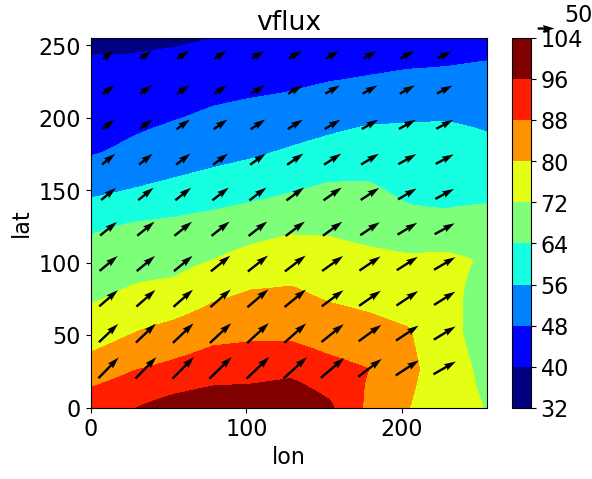

In [254]:
vis_idx(data, idx=0) # 0, mu_ub is the smallest

very strong rainfall, cold front (based on surf_temp and v_flux). Cold fronts tend to facility strong precip. UB reflects strong local rainfall, LB does not.

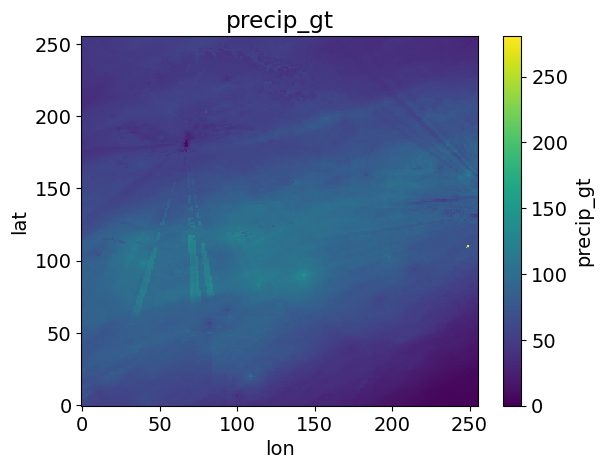

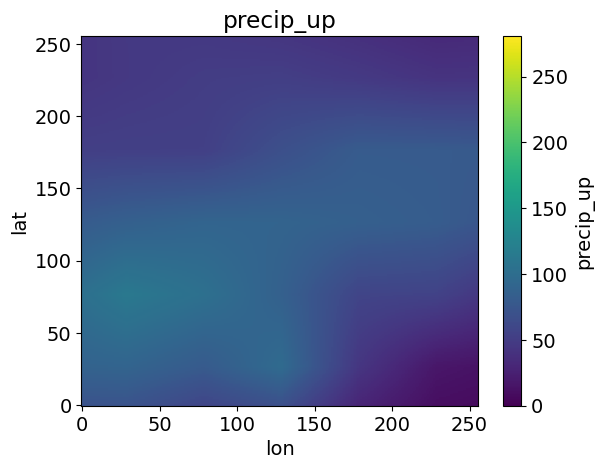

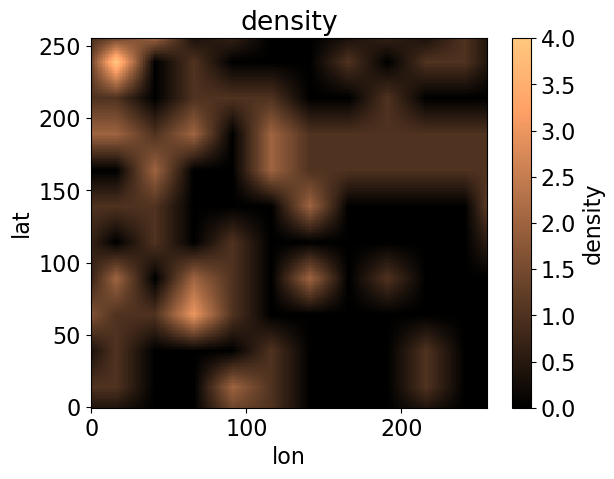

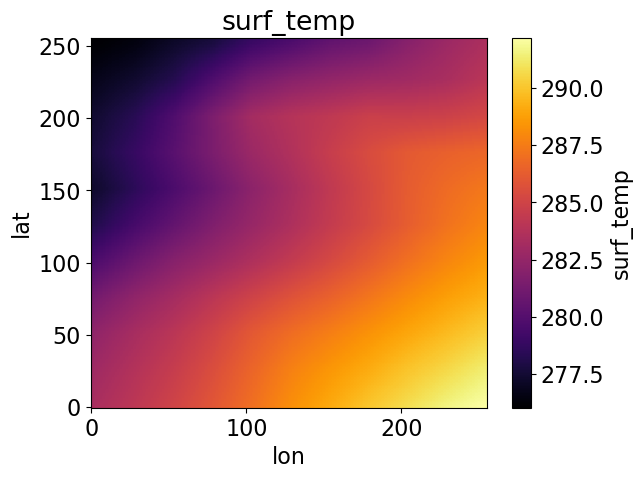

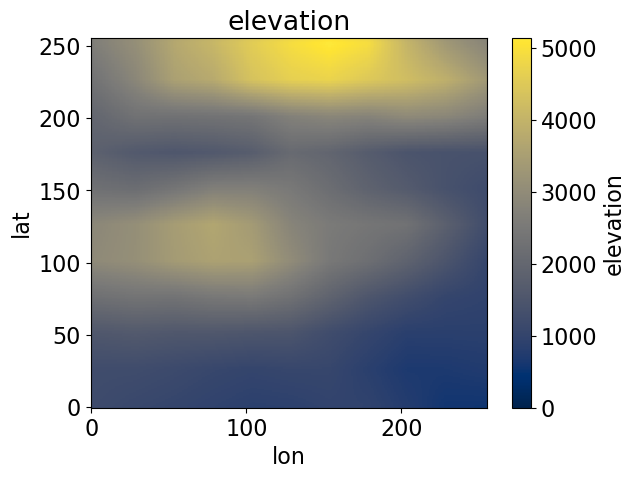

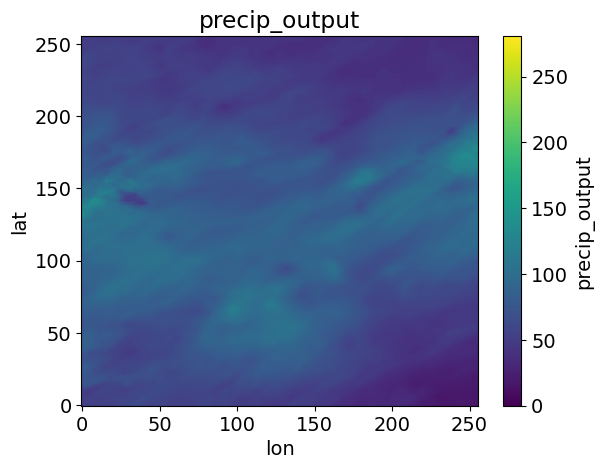

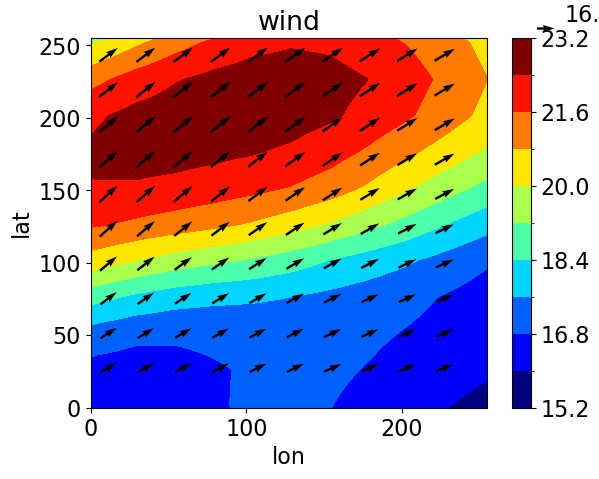

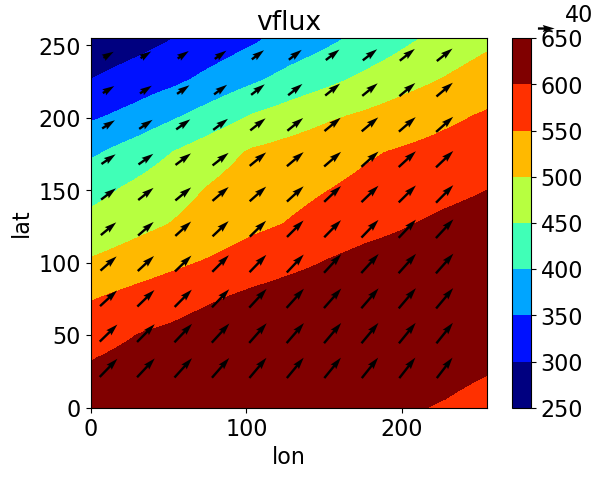

In [256]:
vis_idx(data, idx=62) # 2.png, 

LB is a utter mistake, predicting no rainfall is wrong given precip_up and the pixel values in there.

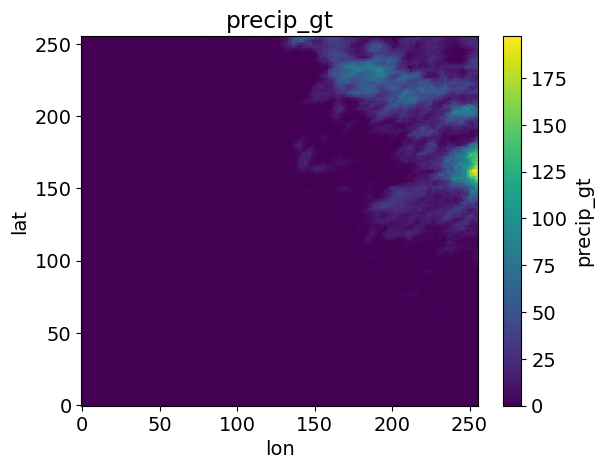

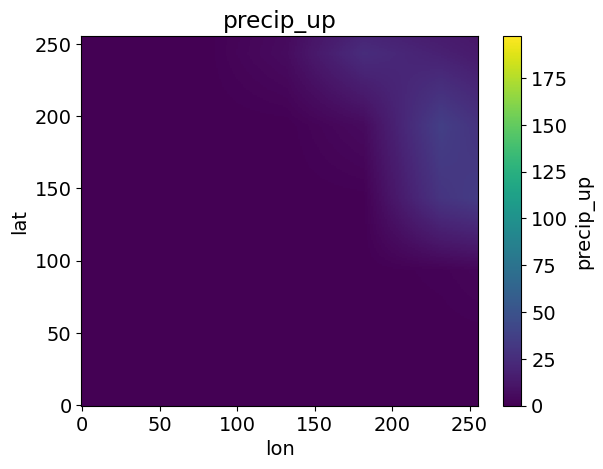

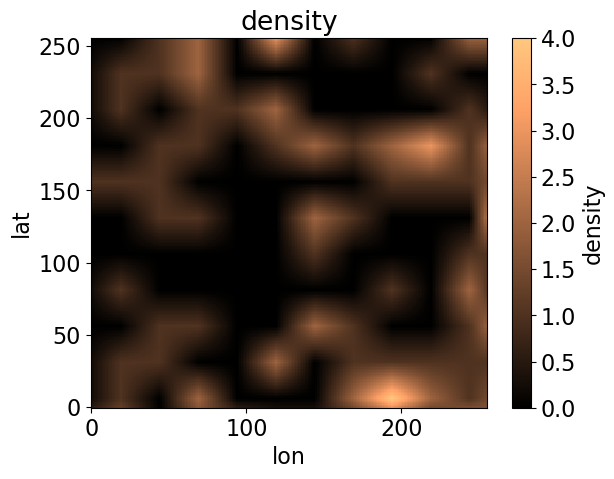

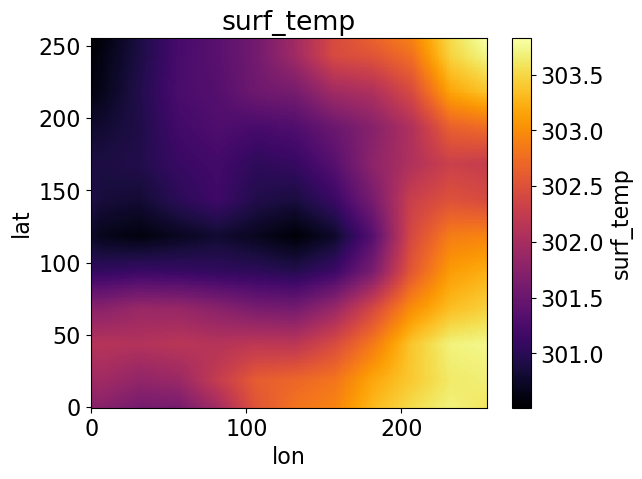

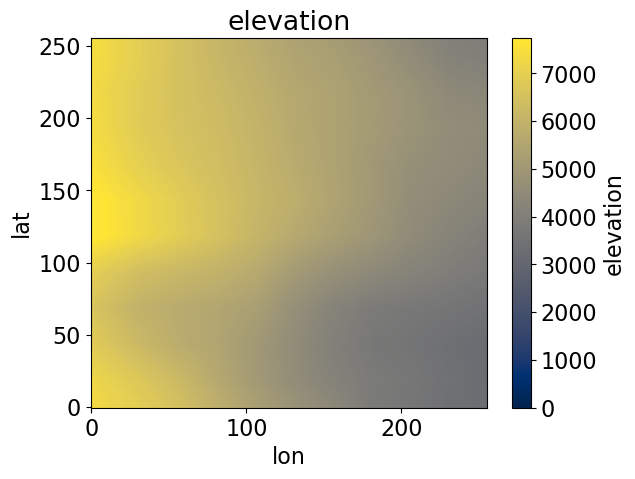

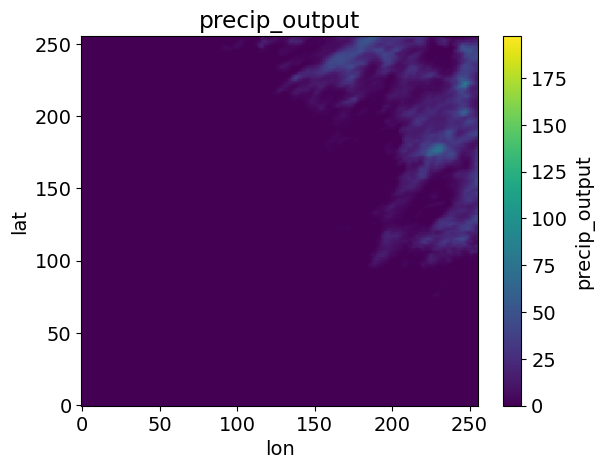

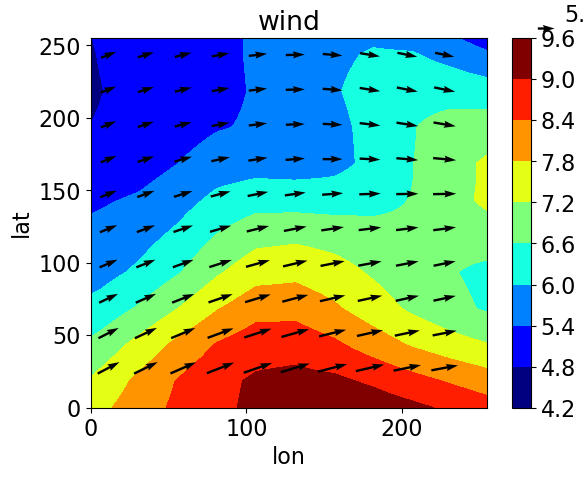

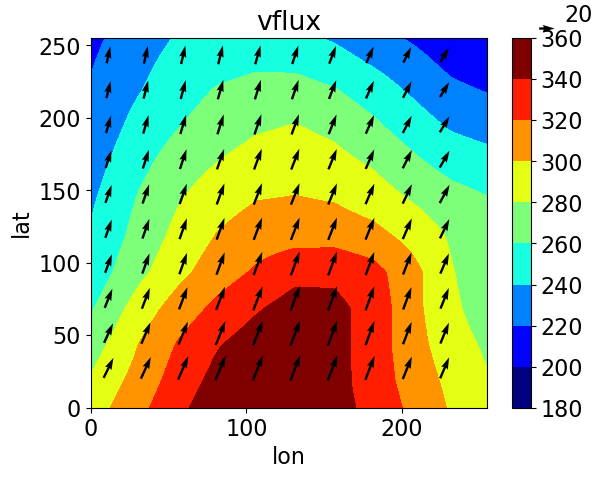

In [258]:
vis_idx(data, idx=59) # 3.png. 

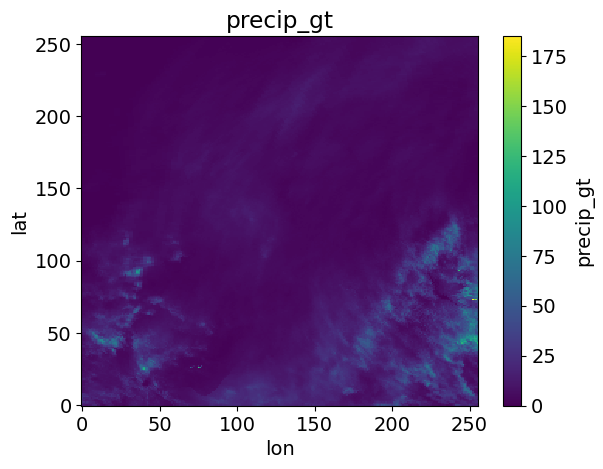

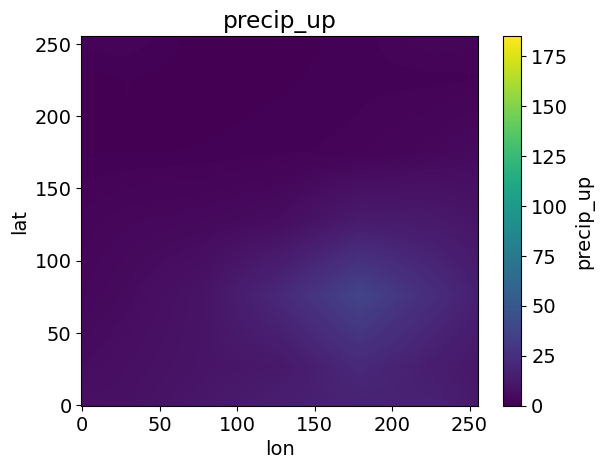

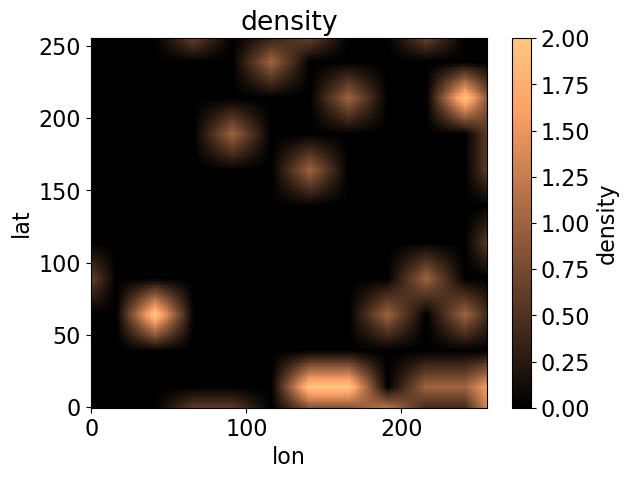

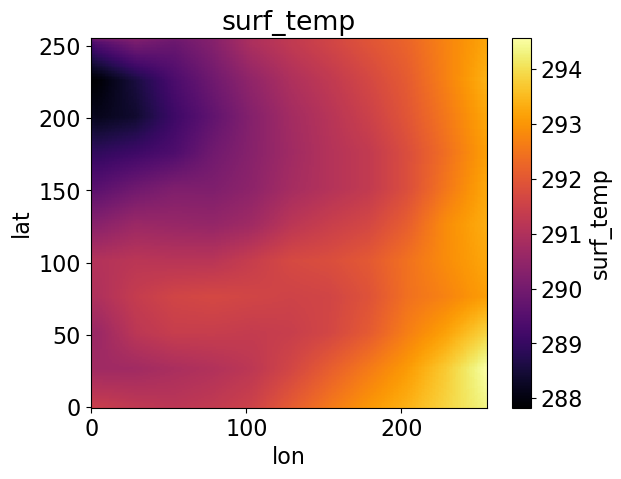

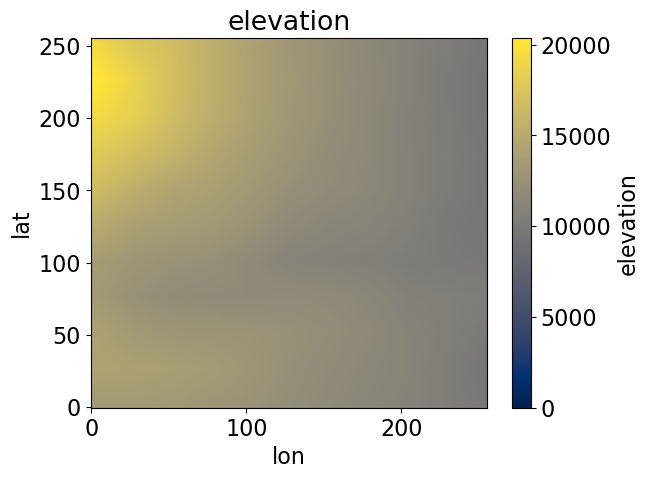

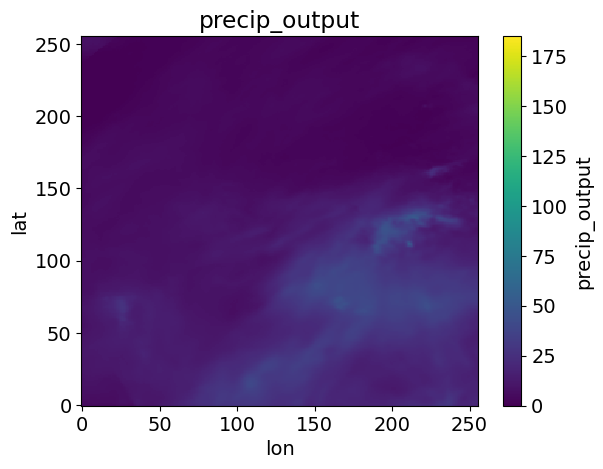

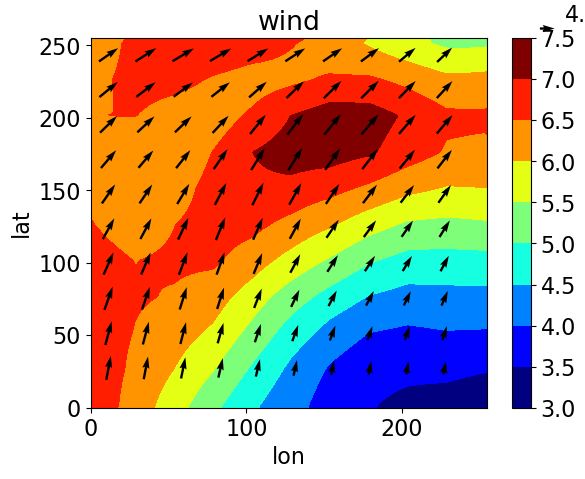

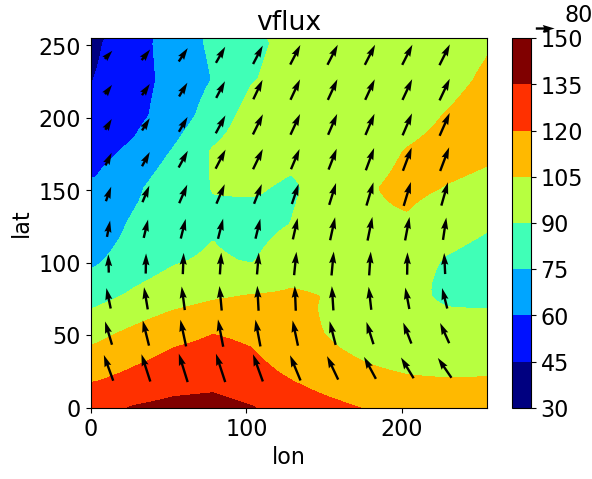

In [260]:
vis_idx(data, idx=119) # 3.png, 

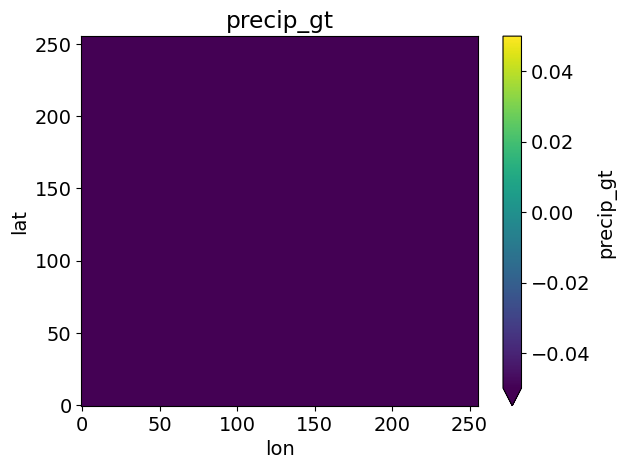

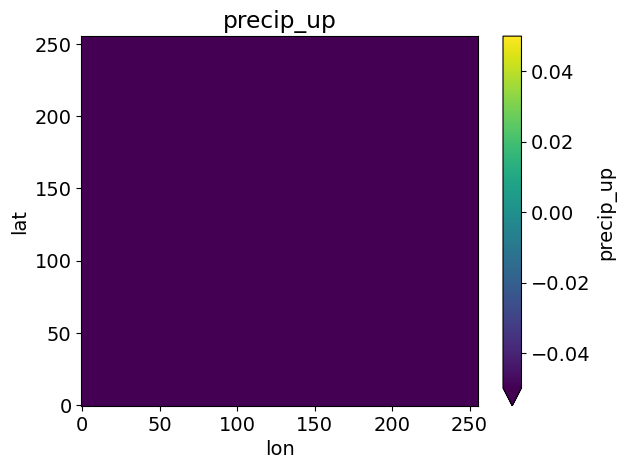

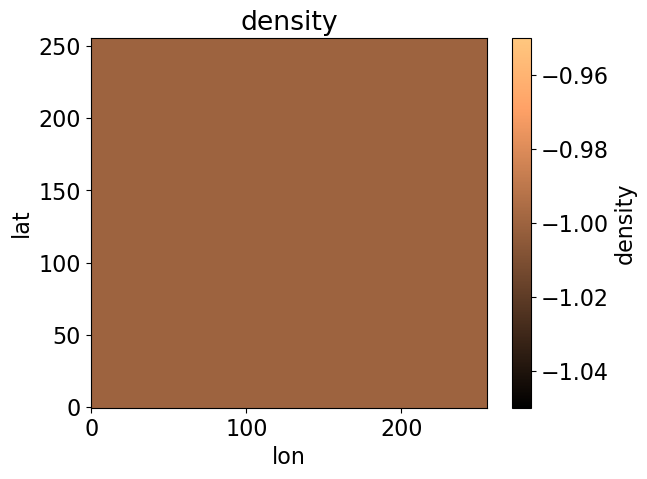

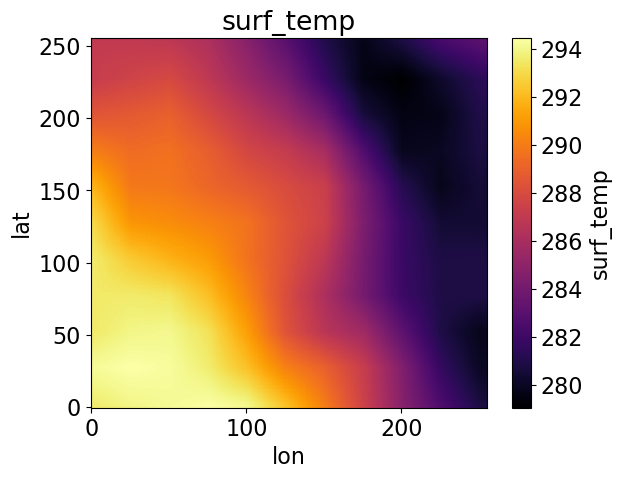

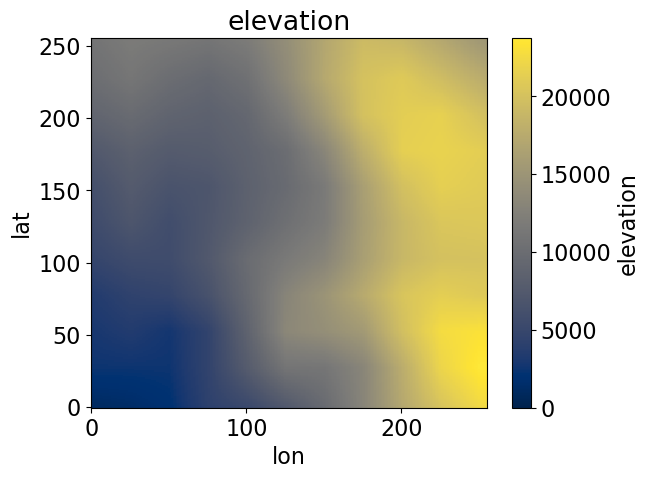

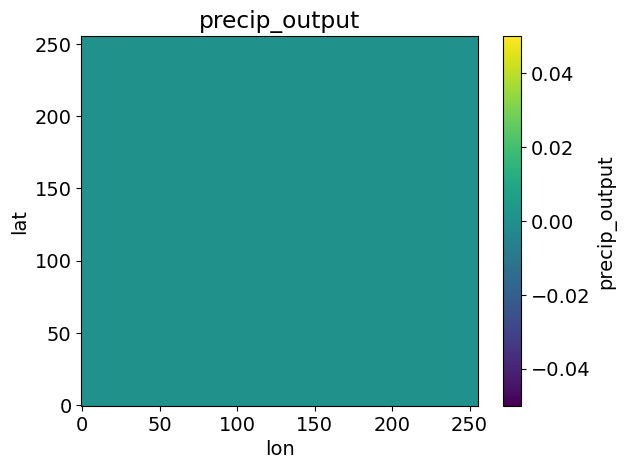

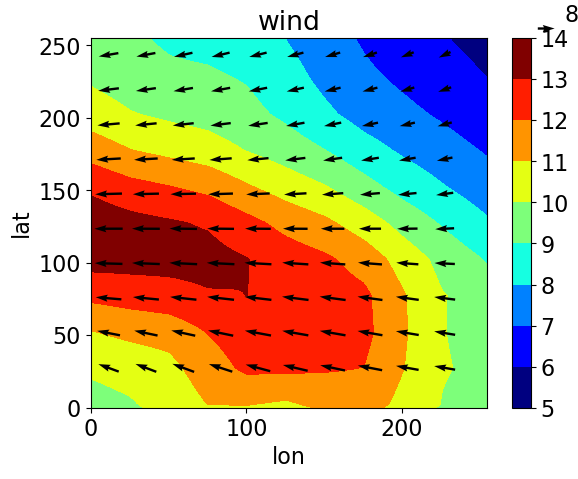

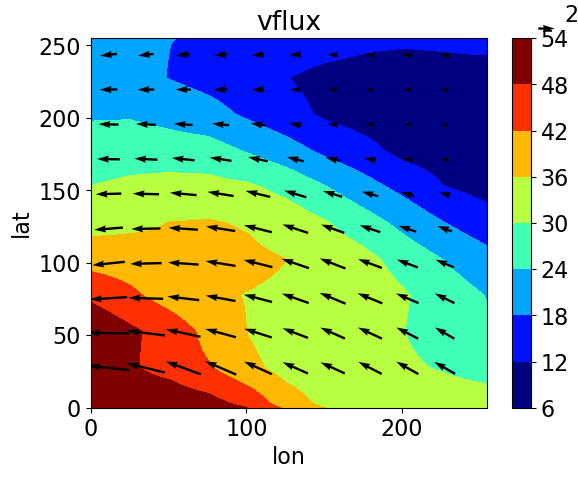

In [265]:
vis_idx(data, idx=116) # 42.png, 

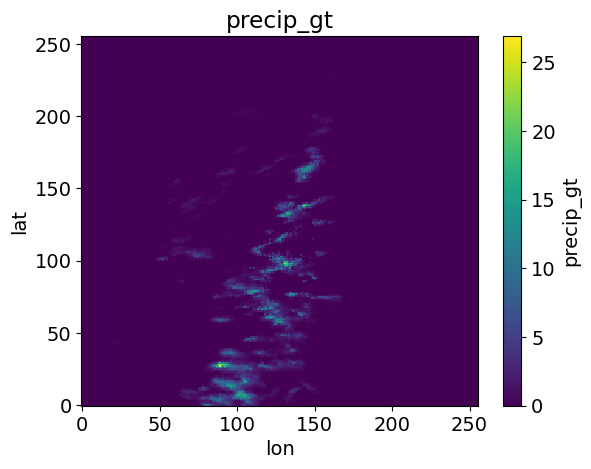

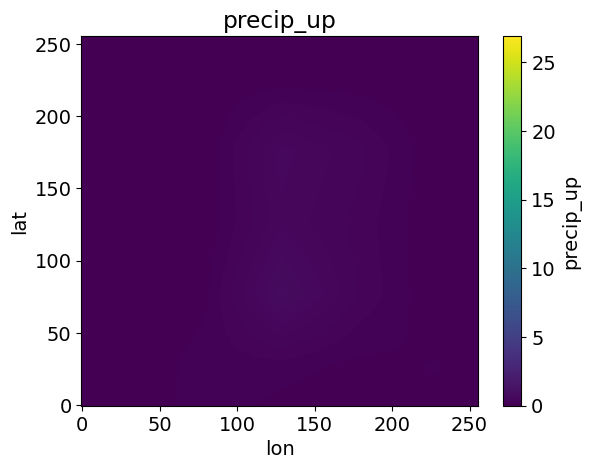

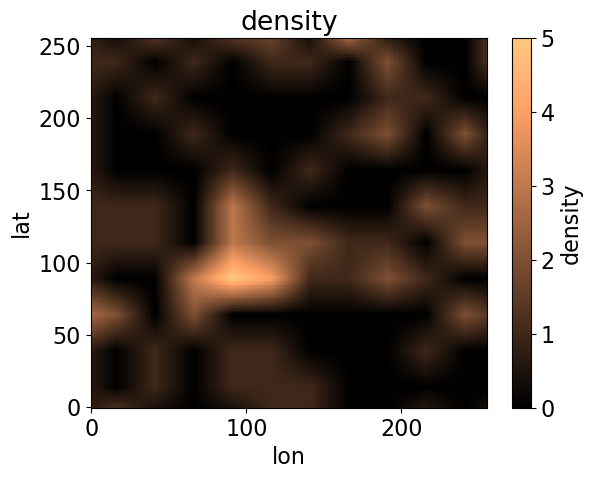

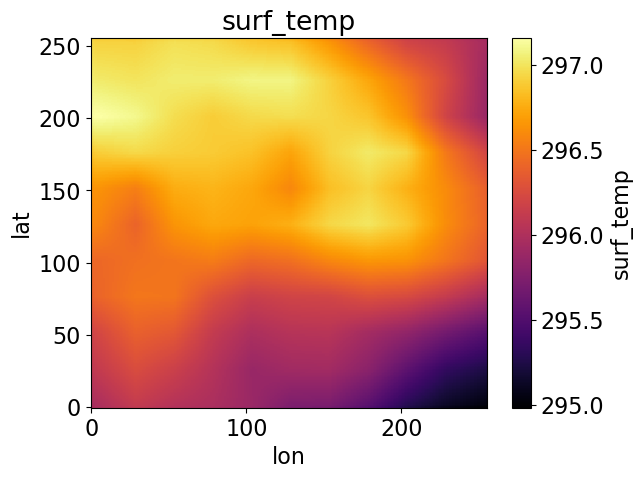

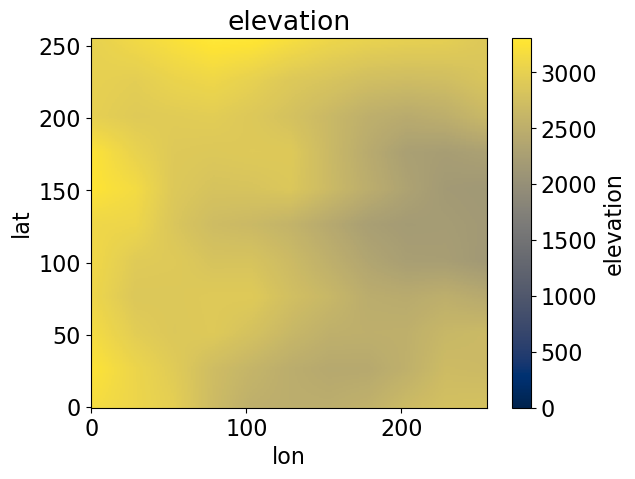

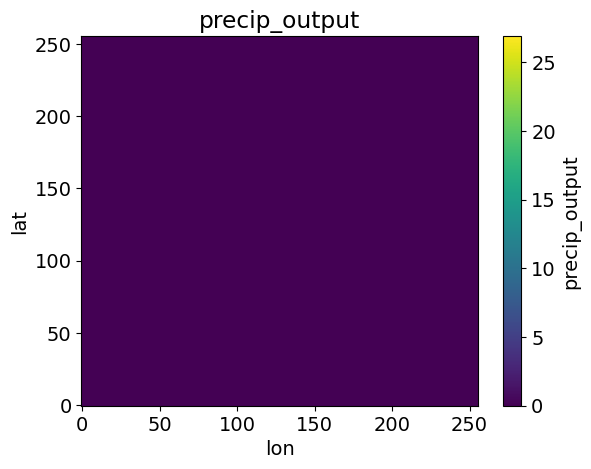

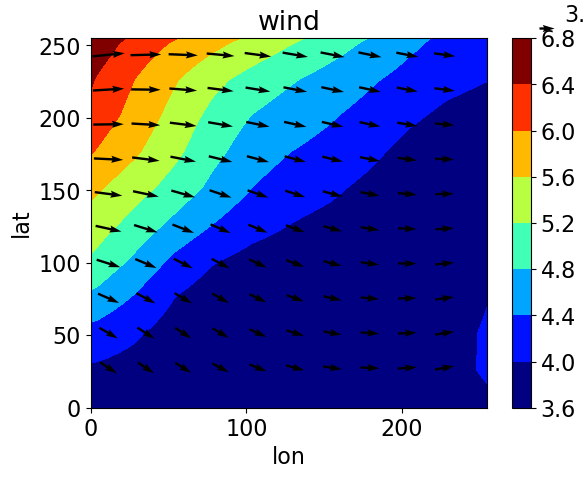

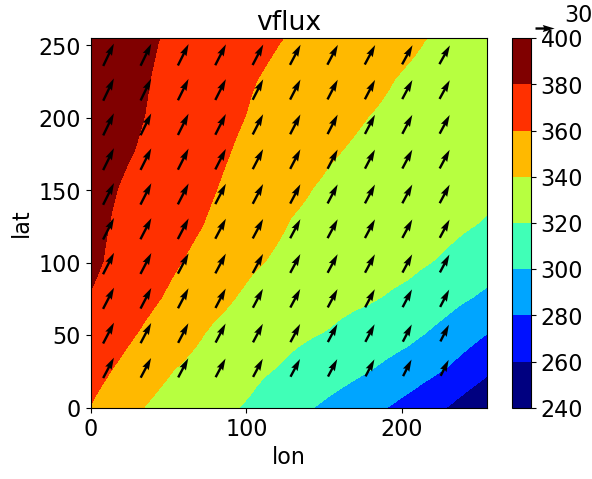

In [263]:
vis_idx(data, idx=46) # 39.png

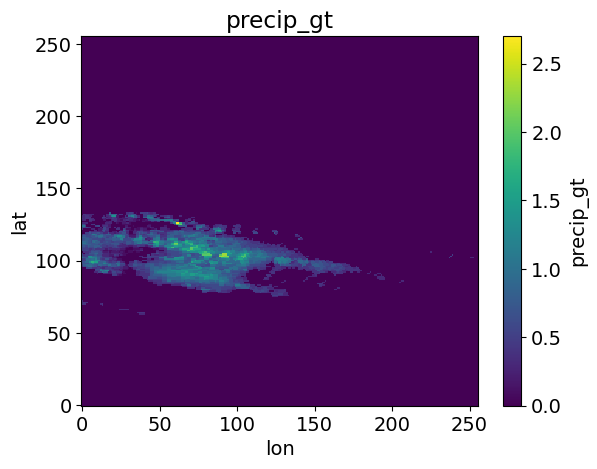

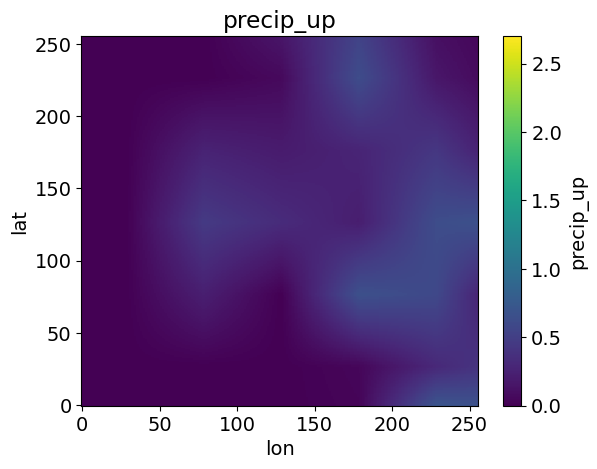

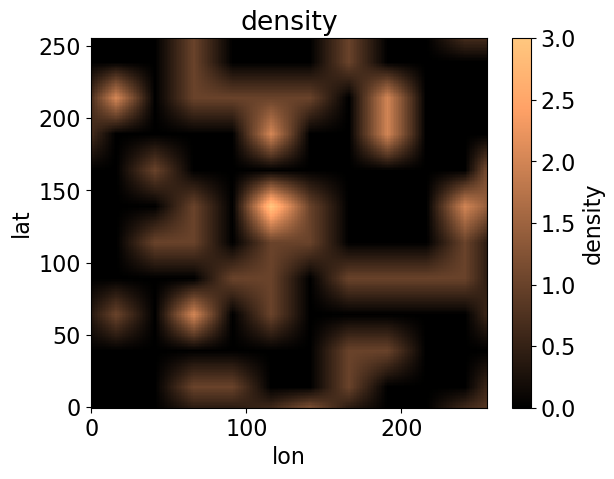

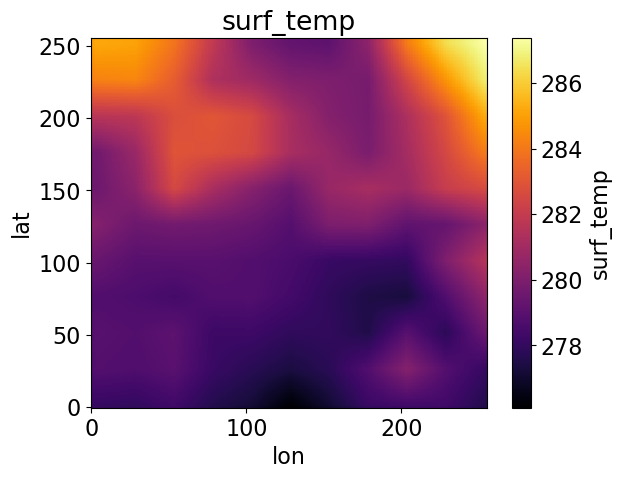

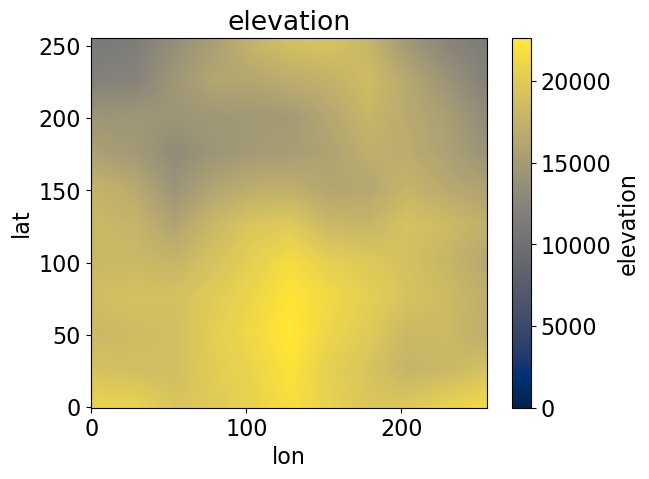

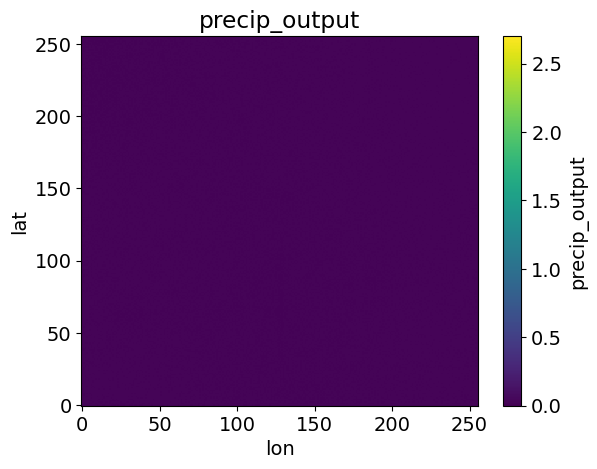

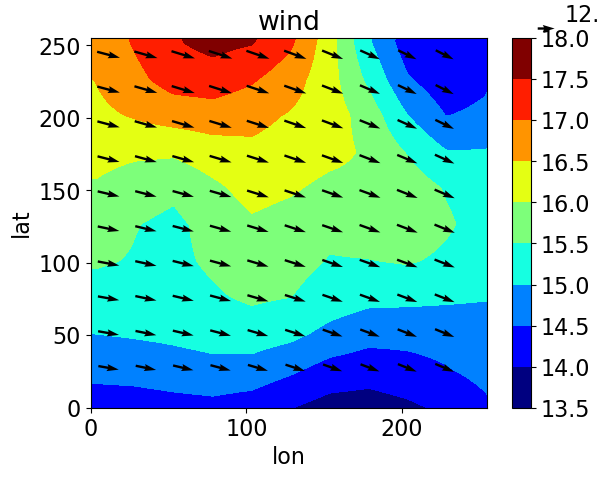

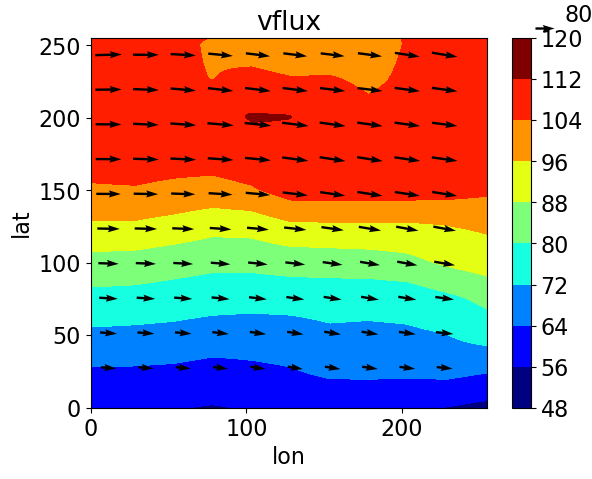

In [269]:
vis_idx(data, idx=171) # ??.png. Strong disagreement between GT and lr_rainfall. Idk what UB and LR looks like (did not find them)

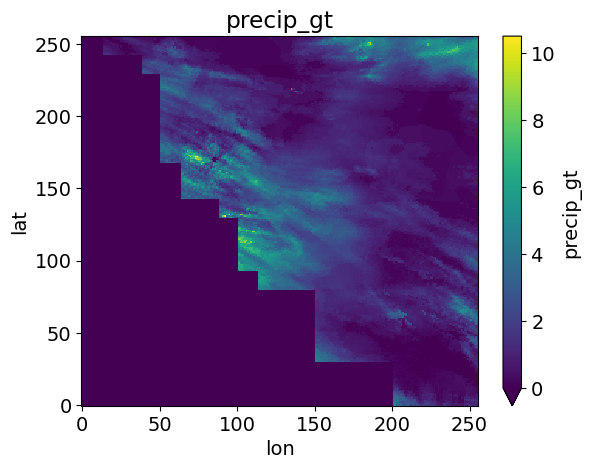

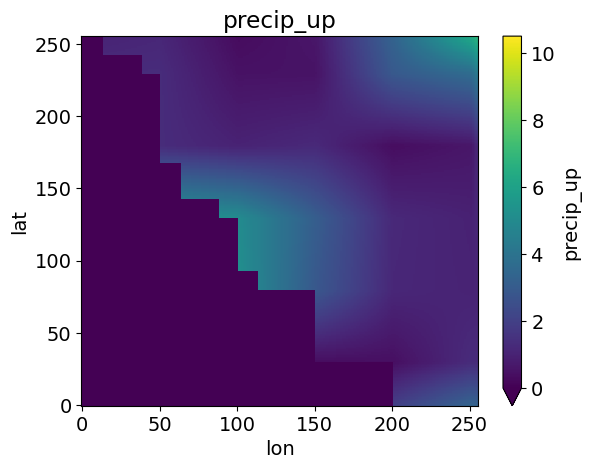

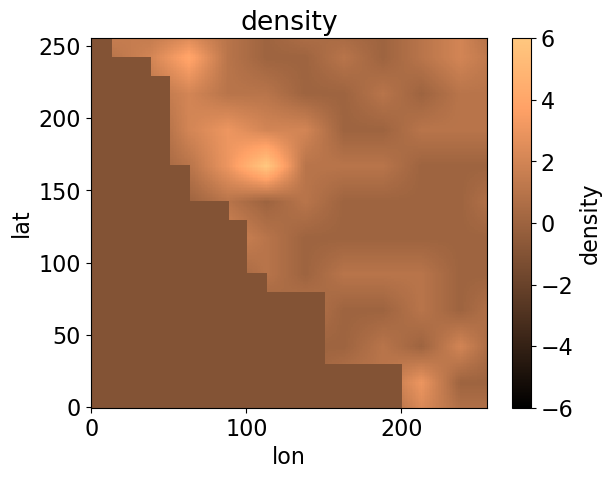

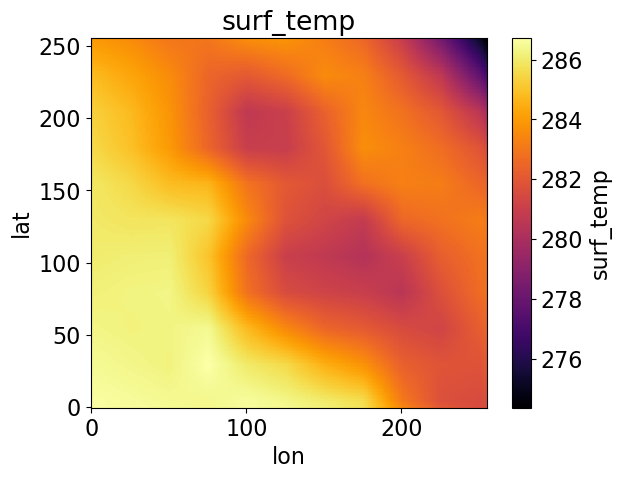

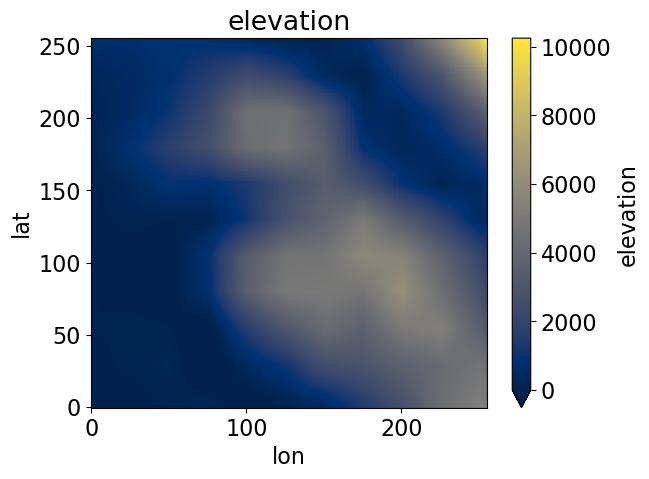

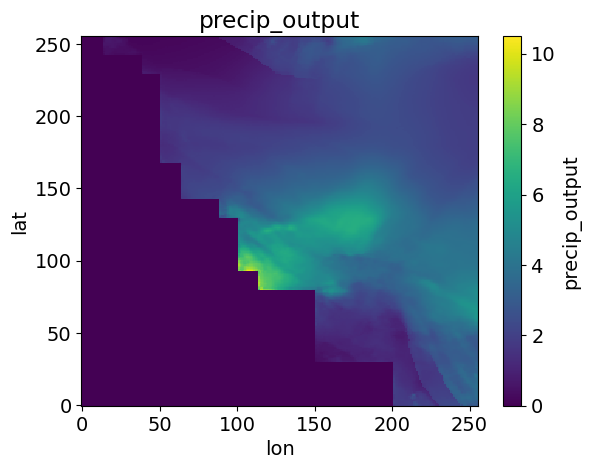

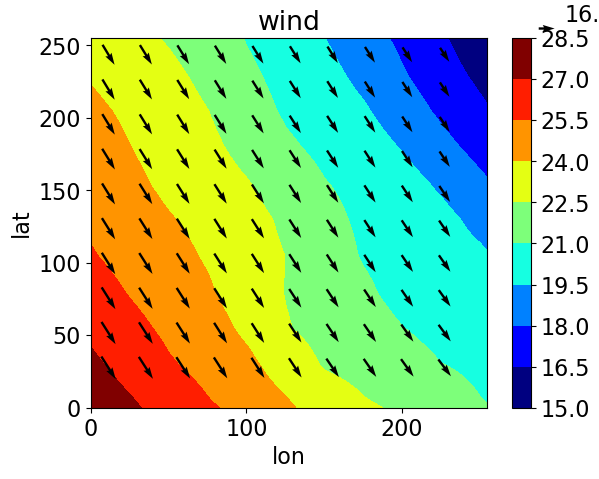

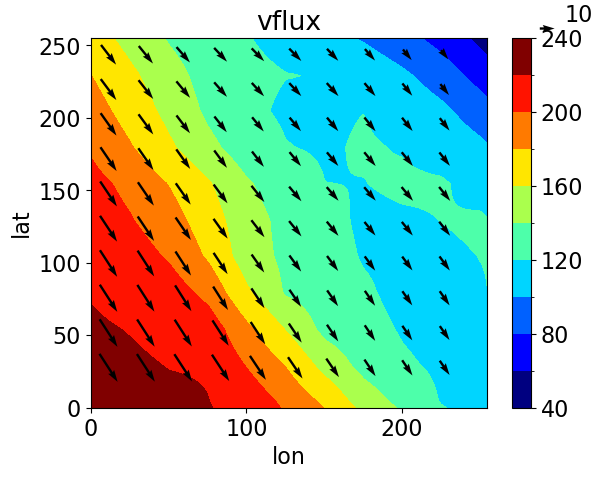

In [270]:
vis_idx(data, idx=133) # 2.png. 